# Figures and tables

### Imports

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime


In [2]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

csfont = {'fontname':'Adobe Garamond Pro','fontsize':30}
hfont = {'fontname':'Adobe Garamond Pro','fontsize':15}

sn.set_style("white")

### Read and prepare Data / Apply general filters

In [3]:
#Read Data
df = pd.read_csv(r"G:\Mi unidad\walknet_datalake\sources\edm2018\level1\level1_edm2018.csv",sep=",")

#Filter Metropolitan Region of Madrid
df = df[df['ZT1259'].str.startswith(("005", "006", "007", "022", "026", "045", "049", "058", "065", "073", "074", "080", "084", "092", "104", "106", "113", "115", "127", "130", "134", "148", "167", "176", "177", "181", "184", "079","123","903"))]
df['CODMUNI'] = df['CODMUNI'].astype(str).str.zfill(3)

#Drop duplicate trips
df.drop_duplicates(subset=['ID_HOGAR','ID_IND','ID_VIAJE'],inplace=True)

#Only one-way trips
df = df[df['VDES']!='Casa']
df = df[df['C8ACTIV']!='Otra situación']

In [4]:
#DateTime format
df['VORIHORAINI'] = df['VORIHORAINI'].astype(int).astype(str).str.zfill(4).str[:2] + ":" + df['VORIHORAINI'].astype(int).astype(str).str.zfill(4).str[2:]
df['VDESHORAFIN'] = df['VDESHORAFIN'].astype(int).astype(str).str.zfill(4).str[:2] + ":" + df['VDESHORAFIN'].astype(int).astype(str).str.zfill(4).str[2:]
df = df[~df['VDESHORAFIN'].str.startswith(("25","26"))]
df = df[~df['VORIHORAINI'].str.startswith(("25","26"))]
df.loc[df['VORIHORAINI'].str.startswith("24"),'VORIHORAINI'] = df[df['VORIHORAINI'].str.startswith("24")]['VORIHORAINI'].str.replace("24:","00:")
df.loc[df['VDESHORAFIN'].str.startswith("24"),'VDESHORAFIN'] = df[df['VDESHORAFIN'].str.startswith("24")]['VDESHORAFIN'].str.replace("24:","00:")
df['VDESHORAFIN'] = pd.to_datetime(df['VDESHORAFIN'], format= '%H:%M' )
df['VORIHORAINI'] = pd.to_datetime(df['VORIHORAINI'], format= '%H:%M' )
df['DURACION_VIAJE'] = ((df['VDESHORAFIN'] - df['VORIHORAINI']).dt.seconds)/60
df['VELOCIDAD_VIAJE'] = df['DISTANCIA_VIAJE']/(df['DURACION_VIAJE']/60)
df['DURACION_VIAJE'].fillna(0,inplace=True)
df['VELOCIDAD_VIAJE'].fillna(0,inplace=True)
df['VDESHORAFIN'] = df['VDESHORAFIN'].dt.hour
df['VORIHORAINI'] = df['VORIHORAINI'].dt.hour

C:\Users\katul\AppData\Local\Temp\ipykernel_9388\404733503.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DURACION_VIAJE'].fillna(0,inplace=True)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\404733503.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [5]:
#Filter initial outliers
df = df[df['VELOCIDAD_VIAJE'] < 80] #Too fast trips
df = df[df['DURACION_VIAJE'] < 300] #Too long (time) trips
df = df[df['DURACION_VIAJE'] >= 0] #Too brief trips
df = df[df['N_VIAJES_POR_HOGAR'] < 20] #Too many trips per household
df = df[df['DISTANCIA_VIAJE'] < 20] #Too long (kilometer) trips

### Read and prepare Data / Map categorical values

In [6]:
categorical = {
    'C2SEXO':('Gender',{'Hombre':'Male','Mujer':'Female'},(0,0)),
    'C4NAC':('Foreign',{'No':'No','Si':'Yes'},(0,1)),
    'CPMR':('PRM',{'No':'No','Si':'Yes'},(1,0)),
    'C13TARJETA':('TravelCard',{'Tarjeta de Transporte Público TTP':"Yes", 'Ninguna':"No", 'Ambas tarjetas':"Yes",'Tarjeta MULTI':"Yes"},(1,1)),
    'VVEHICULO':('HasVehicle',{'Si':'Yes','No':'No'},(2,0)),
    'C6CARNE':('HasLicense',{'No tiene':"No", 'Carné de coche (B) o superior  (C, D ó E)':"Yes",'Carné de moto y coche':"Yes", 'Carné de moto A1/A2':"Yes", 'Sólo licencia de ciclomotor':"Yes"},(2,1)),
    'VFRECUENCIA':('Frequency',{'A diario, de lunes a viernes':"Daily",'Entre 2 y 4 días laborables por semana':"Frequently",'Es la primera vez que hago el viaje':"0",'Menos de dos días laborables por semana':"Less Frequently", 'Alguna vez':"Sometimes"},(3,0)),
    'DIASEM':('DayOfWeek',{"Lunes":"Monday","Martes":"Tuesday","Miércoles":"Wednesday","Jueves":"Thursday"},(3,1)),
    'C7ESTUD':('EducationLevel',{'Primera etapa de Educación Secundaria y similar':"Second - A",'Educación Primaria':"First",'Segunda etapa de Educación Secundaria y similar':"Second - B",'Menos que Primaria':"No",'Enseñanzas de Formación Profesional de grado superior y equivalentes':"Third",'Educación postsecundaria no superior':"Second - B", 'Grados universitarios/licenciaturas/másteres y enseñanzas de doctorado':"Third"},(4,0)),
    'C8ACTIV':('Activity',{'Parado, ha trabajado antes':"Unemployed", 'Jubilado / Retirado/ Pensionista':"Retired",'Estudiante':"Student", 'Trabaja':"Worker", 'Trabaja y estudia':"Worker",'Cuidado de familiares':"Caretaker", 'Trabajo doméstico no remunerado':"Caretaker", 'Parado, busca primer trabajo':"Unemployed"},(4,1)),
    'VNOPRIVADO':("NoPrivate",{'No me gusta el coche':"Dislike", 'Más incómodo':"Less Convenient",'Evitar el atasco':"Congestion",'Contamino menos':"Other",'Dificultad de aparcamiento':"Hard to Park",'Otros':"Other",'Tardo más':"Takes Longer",'Es más caro':"Other"},(5,0)),
    'VNOPUBLICO':("NoPublic",{'No hay servicio público':"Bad Service",'Es más caro':"Other",'Tardo más':"Takes Longer",'El destino está muy cerca':"Very Close",'Otros':"Other",'Necesito mi vehículo para trabajar o gestión personal':"Other",'Mala combinación del tte.público':"Bad Service",'Prefiero ir andando / en bicicleta':"Prefer Active Modes",'Mi situación personal condiciona esta elección modal':"Bad Service",'Más incómodo':"Less Convenient", 'Por desconocimiento/falta de información':"Other",'No me gusta el tte. público':"Other"},(5,1)),
    "MOTIVO_PRIORITARIO":("TripPurpose",{'Compras':"Shopping",'Ocio':"Leisure",'Estudio':"Study",'Trabajo':"Work",'Deporte/ dar un paseo':"Sport / Stroll",'Otro domicilio':"Other",'Asunto personal':"Other",'Acompañamiento a otra persona':"Care",'Médico':"Care",'Gestión de trabajo':"Work",'Otros':"Other"},(6,0)),
    "MODO_PRIORITARIO":("TransportMode",{'Coche conductor particular' :"Motor - Personal",'Coche pasajero particular':"Motor - Personal",'Moto/ciclomotor particular':"Motor - Personal",'Andando/pie' : "Walking",'Autobus urbano Madrid EMT':"Bus",'Autobus interurbano':"Bus",'Autobus discrecional':"Bus",'Autobus de largo recorrido':"Bus",'Autobus urbano otro municipio':"Bus",'Otros':"Other",'Metro':"Train",'Renfe Cercanías':"Train",'Resto renfe':"Train",'Metro ligero/tranvía':"Train", 'Coche conductor empresa' : "Motor - Shared",'Coche pasajero empresa': "Motor - Shared",'Taxi':"Motor - Shared",'Coche pasajero alquiler con conductor': "Motor - Shared",'Coche conductor alquiler sin conductor': "Motor - Shared",'Moto/ciclomotor empresa': "Motor - Shared",'Moto/ciclomotor publica': "Motor - Shared",'Bicicleta particular':"Cycling",'Bicicleta publica':"Cycling",'Bicicleta empresa':"Cycling"},(6,1))
    }

#Iterate over categorical columns and rename
for c,i in categorical.items():
    df[c] = df[c].map(i[1])
    df.rename(columns={c:i[0]},inplace=True)

### Read and prepare Data / Prepare continuous columns

In [7]:
df.rename(columns = {'DISTANCIA_VIAJE':'TripDistance'},inplace=True)
continuous = {
    'EDAD_FIN':('Age',(0,0)),
    'N_MIEMBROS_POR_HOGAR':('HouseholdSize',(0,1)),
    'N_VIAJES_POR_HOGAR':('TripsHousehold',(1,0)),
    'N_ETAPAS_POR_VIAJE':('TripStages',(1,1)),
    'VORIHORAINI':('StartTime',(2,0)),
    'VDESHORAFIN':('EndTime',(2,1)),
    'DURACION_VIAJE':('TripDuration',(3,0)),
    'VELOCIDAD_VIAJE':('TripSpeed',(3,1))
    }

#Iterate over continuous columns and rename
for c,i in continuous.items():
    df.rename(columns={c:i[0]},inplace=True)
    df[i[0]] = df[i[0]].astype(float)



### Read and prepare Data / Prepare age and household structure columns

In [8]:

df.loc[df['Age']<5,'Age Status'] = "Less than 5"
df.loc[(df['Age']>=5) & (df['Age']<12),'Age Status'] = "Ages 6-12"
df.loc[(df['Age']>=12) & (df['Age']<18),'Age Status'] = "Ages 13-18"
df.loc[(df['Age']>=18) & (df['Age']<40),'Age Status'] = "Ages 19-40"
df.loc[(df['Age']>=40) & (df['Age']<65),'Age Status'] = "Ages 41-65"
df.loc[df['Age']>=65,'Age Status'] = "More than 65"

hd = {}
h15 = {}
h30 = {}
for h in list(df['ID_HOGAR'].unique()):
    dist = list(df[df['ID_HOGAR'] == h]['TripDuration'].values)
    
    if all(di < 30 for di in dist): h30.update({h:1})
    else: h30.update({h:0})
    
    if all(di < 15 for di in dist): h15.update({h:1})
    else: h15.update({h:0})

    hd.update({h:'Other'})
    d = df[df['ID_HOGAR'] == h][['ID_IND','Age','Age Status','HouseholdSize','Activity']].drop_duplicates(subset='ID_IND')
    if d['HouseholdSize'].values[0] == 1:
        if d['Activity'].values[0] == 'Retired': hd.update({h:'Retirees'})
        elif d['Activity'].values[0] == 'Student': hd.update({h:'Students (age 19+)'})
        elif d['Activity'].values[0] in ['Worker']: hd.update({h:'Full-Time Workers'})
        else: hd.update({h:'Other'})
    else:
        if any(act in ['Retired'] for act in d['Activity'].values): hd.update({h:'Retirees'})
        if any(act in ['Worker'] for act in d['Activity'].values): hd.update({h:'Full-Time Workers'})
        if any(age == "Ages 13-18" for age in d['Age Status'].values): hd.update({h:'Students (Age 13–18)'})
        if any(age == "Ages 6-12" for age in d['Age Status'].values): hd.update({h:'Students (Age 6–12)'})
        if any(age == "Less than 5" for age in d['Age Status'].values): hd.update({h:'Children'})
        

df['HouseholdStructure'] = df['ID_HOGAR'].map(hd)
df['Household15min'] = df['ID_HOGAR'].map(h15)
df['Household30min'] = df['ID_HOGAR'].map(h30)

df['Household30min'] = df['Household30min'].map({0:"No",1:"Yes"})
df['Household15min'] = df['Household15min'].map({0:"No",1:"Yes"})



### Read and prepare Data / Filter 15 minute trips

In [9]:
df['Trip15'] = ""
df.loc[df['TripDuration']<=15,'Trip15'] = 'Yes'
df.loc[df['TripDuration']>15,'Trip15'] = 'No'

In [10]:
"""
filters = {'Activity' : ['Retired', 'Worker', 'Student', 'Caretaker'],
'Age Status' : ['More than 65', 'Ages 41-65', 'Ages 19-40', 'Ages 13-18','Ages 6-12', 'Less than 5']}
"""

"\nfilters = {'Activity' : ['Retired', 'Worker', 'Student', 'Caretaker'],\n'Age Status' : ['More than 65', 'Ages 41-65', 'Ages 19-40', 'Ages 13-18','Ages 6-12', 'Less than 5']}\n"

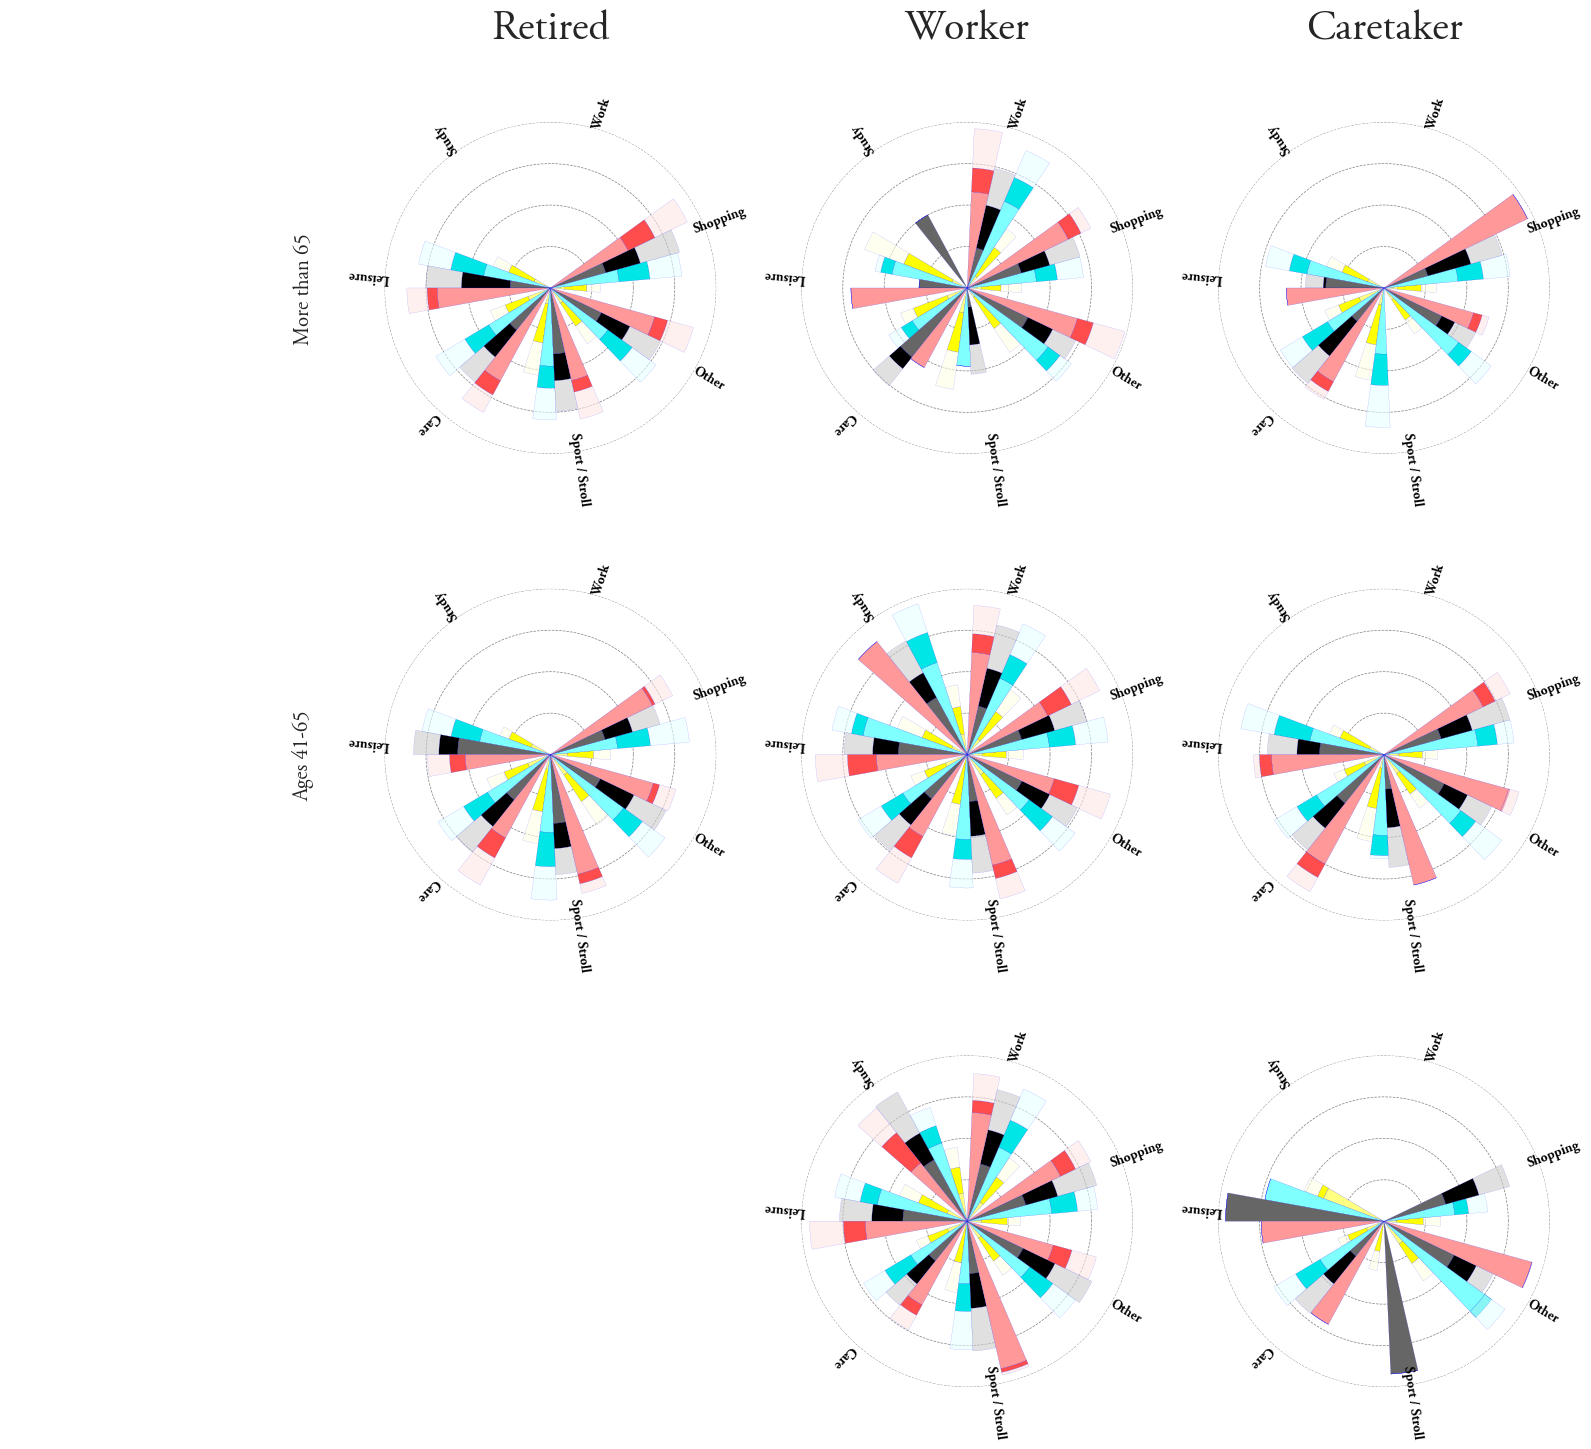

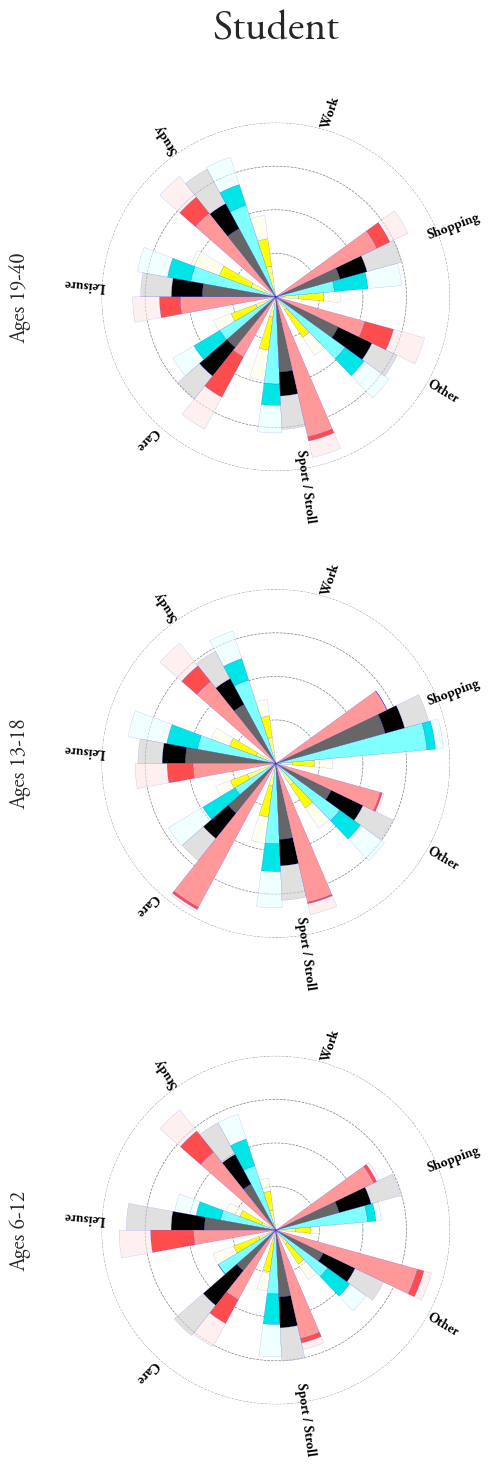

In [11]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration and synthetic data generation
np.random.seed(42)

# Sample data generation for demonstration
modos_transporte = ['Walking', 'Bus', 'Motor - Personal', 'Train']
motivos_viaje = ['Shopping', 'Work', 'Study', 'Leisure', 'Care', 'Sport / Stroll', 'Other']
activities = ['Retired', 'Worker', 'Student', 'Caretaker']
age_statuses = ['More than 65', 'Ages 41-65', 'Ages 19-40', 'Ages 13-18', 'Ages 6-12', 'Less than 5']

# Color scheme
colores_tonos_6 = {
    'Train': ['#ff9999', '#ff4d4d', '#ffe6e6'],           # Lightest, medium, and main color (red)
    'Motor - Personal': ['#666666', '#000000', '#cccccc'], # Lightest, medium, and main color (black)
    'Bus': ['#80ffff', '#00e6e6', '#e6ffff'],              # Lightest, medium, and main color (cyan)
    'Walking': ['#ffff80', '#ffff00', '#ffffe6']           # Lightest, medium, and main color (yellow)
}

d = df[df['TripPurpose'].isin(motivos_viaje)]
d = d[d['TransportMode'].isin(modos_transporte)]
d = d[d['TripDistance'] < 2]
d = d[d['Activity'].isin(activities)]

def crear_grafico(colores_tonos, df_filtered, ax):
    if df_filtered.empty:
        return  # Skip plotting if the filtered DataFrame is empty

    # Create a complete multi-index for all combinations of TripPurpose and TransportMode
    idx = pd.MultiIndex.from_product([motivos_viaje, modos_transporte], names=['TripPurpose', 'TransportMode'])
    
    # Group and calculate metrics, then reindex to include all combinations
    mean_distances_filtered = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].mean().reindex(idx, fill_value=0).reset_index()
    mean_distances_filtered['Max Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.75).reindex(idx, fill_value=0).values
    mean_distances_filtered['Min Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.25).reindex(idx, fill_value=0).values

    # Angles and colors
    num_motivos = len(motivos_viaje)
    num_bars = len(mean_distances_filtered)
    
    angle_step = 2 * np.pi / num_motivos
    bar_width = angle_step / (num_bars / num_motivos) * 0.8  # Increase spacing by reducing bar width

    # Calculate start angles and center angles for each trip purpose
    motivo_angles_start = {
        motivo: idx * angle_step
        for idx, motivo in enumerate(motivos_viaje)
    }

    motivo_angles_center = {
        motivo: (idx * angle_step) + (angle_step / 2)
        for idx, motivo in enumerate(motivos_viaje)
    }

    for i, row in mean_distances_filtered.iterrows():
        trip_purpose = row['TripPurpose']
        angle = motivo_angles_start[trip_purpose] + ((i % (num_bars // num_motivos)) * bar_width)
        modo = row['TransportMode']
        ax.bar(x=angle, height=row['Min Quartile'], width=bar_width, color=colores_tonos[modo][0],linewidth= 0.1, edgecolor = 'b')
        ax.bar(x=angle, height=row['TripDistance'] - row['Min Quartile'], width=bar_width, bottom=row['Min Quartile'], color=colores_tonos[modo][1],linewidth= 0.1, edgecolor = 'b')
        ax.bar(x=angle, height=row['Max Quartile'] - row['TripDistance'], width=bar_width, bottom=row['TripDistance'], color=colores_tonos[modo][2], alpha=0.6,linewidth= 0.1, edgecolor = 'b',
               label=modo if i % (num_bars // len(modos_transporte)) == 0 else "")

    # Set the ticks and labels at the center of each segment
    ax.set_xticks([motivo_angles_center[motivo] for motivo in motivos_viaje])
    ax.set_xticklabels([])  # Remove default labels

    # Add custom labels with larger font size and adjust their positions
    label_distance = 2.2  # Distance from the center
    label_angle_adjustment = bar_width / 2  # Adjust by half the bar width
    rotation_offset = - np.radians(10)  # 10 degrees in radians

    for trip_purpose, angle in motivo_angles_center.items():
        adjusted_angle = angle + label_angle_adjustment + rotation_offset
        ax.text(adjusted_angle, label_distance, trip_purpose, horizontalalignment='center', color='black', weight='bold', rotation=np.degrees(adjusted_angle), rotation_mode='anchor', size=10, fontname = 'Adobe Garamond Pro')

    # Draw reference circles and labels
    for distance in np.arange(0.5, 2.5, 0.5):
        ax.plot(np.linspace(0, 2 * np.pi, 100), np.ones(100) * distance, color='grey', linestyle='--', linewidth=0.5, zorder=0)

    # Remove radial lines
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.yaxis.set_tick_params(width=0)
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_yticklabels([])

    plt.ylim(0, 2)

# Function to create the plots
def create_plots(valid_combinations, activities, age_statuses, filename, ncols):
    fig, axes = plt.subplots(len(age_statuses), len(activities), figsize=(ncols * 5, 15), subplot_kw=dict(polar=True),sharey=True)

    if len(activities) == 1:
        axes = np.expand_dims(axes, axis=-1)

    # Add the column titles
    for ax, activity in zip(axes[0], activities):
        ax.set_title(activity, pad=60,
                      #size=20,
                      **csfont)


    # Add the row titles
    for ax, age_status in zip(axes[:, 0], age_statuses):
        ax.annotate(age_status, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    #size=20, 
                    ha='center', va='center', rotation=90,**hfont)

    for i, activity in enumerate(activities):
        for j, age_status in enumerate(age_statuses):
            ax = axes[j, i]
            if (activity, age_status) in valid_combinations:
                df_filtered = d[(d['Activity'] == activity) & (d['Age Status'] == age_status)]
                crear_grafico(colores_tonos_6, df_filtered, ax)
            else:
                ax.axis('off') 

    # Create a legend
    legend_colors = {
        'Train': 'red',         
        'Motor - Personal': 'black',
        'Bus': 'cyan',          
        'Walking': 'yellow'
    }

    #legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=mode) for mode, color in legend_colors.items()]
    #fig.legend(handles=legend_elements, loc='lower left', fontsize=20)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Create first figure
valid_combinations_1 = [("Retired", "More than 65"), ("Retired", "Ages 41-65"), 
                        ("Worker", "More than 65"), ("Worker", "Ages 41-65"), ("Worker", "Ages 19-40"),
                        ("Caretaker", "More than 65"), ("Caretaker", "Ages 41-65"), ("Caretaker", "Ages 19-40")]

activities_1 = ['Retired', 'Worker', 'Caretaker']
age_statuses_1 = ['More than 65', 'Ages 41-65', 'Ages 19-40']
create_plots(valid_combinations_1, activities_1, age_statuses_1, r"C:\Users\katul\OneDrive\Escritorio\tripdistance_figure1.jpg",3)

# Create second figure
valid_combinations_2 = [("Student", "Ages 19-40"), ("Student", "Ages 13-18"), ("Student", "Ages 6-12")]
activities_2 = ['Student']
age_statuses_2 = ['Ages 19-40', 'Ages 13-18', 'Ages 6-12']
create_plots(valid_combinations_2, activities_2, age_statuses_2, r"C:\Users\katul\OneDrive\Escritorio\tripdistance_figure2.jpg",1)





In [12]:
#FINAL VERSION BELOW

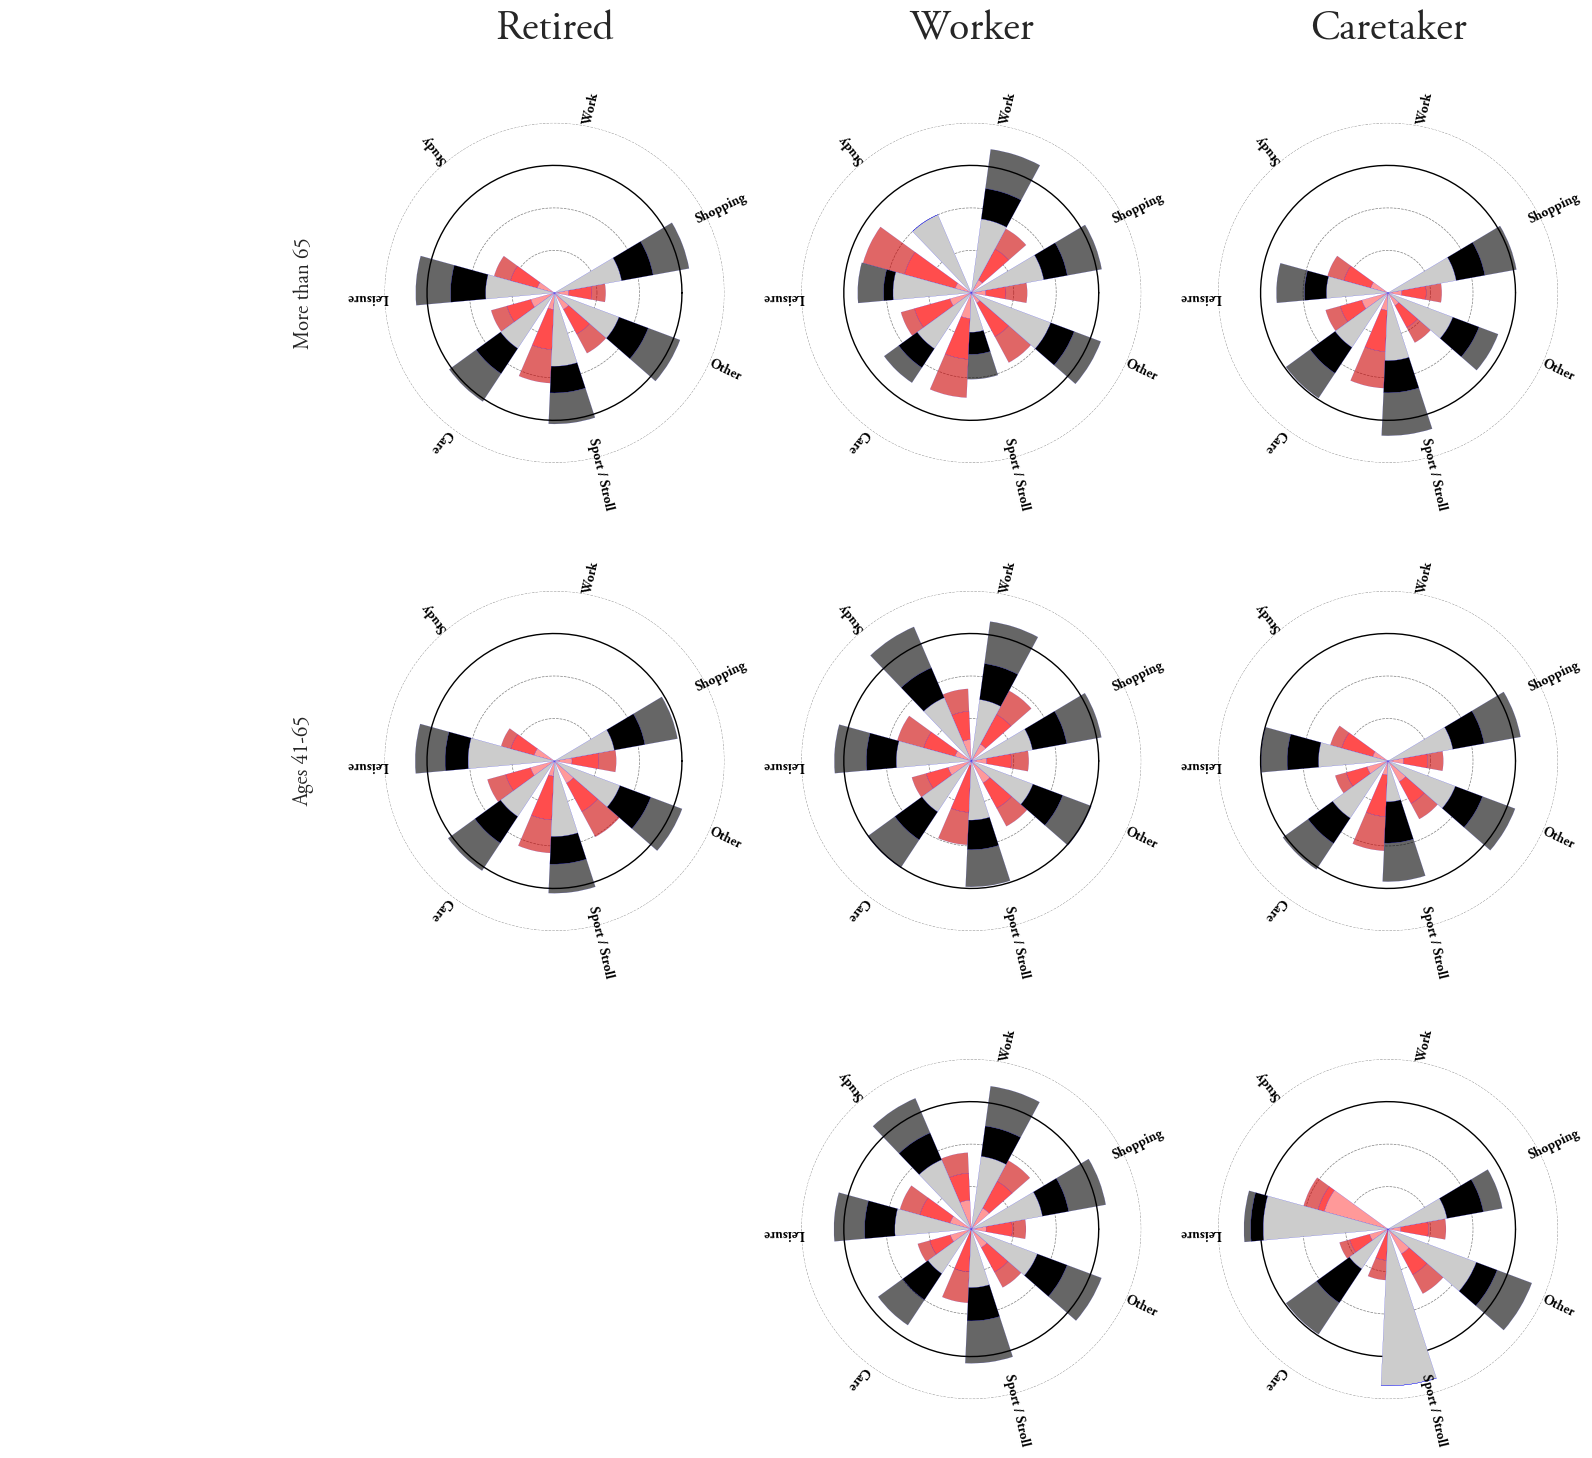

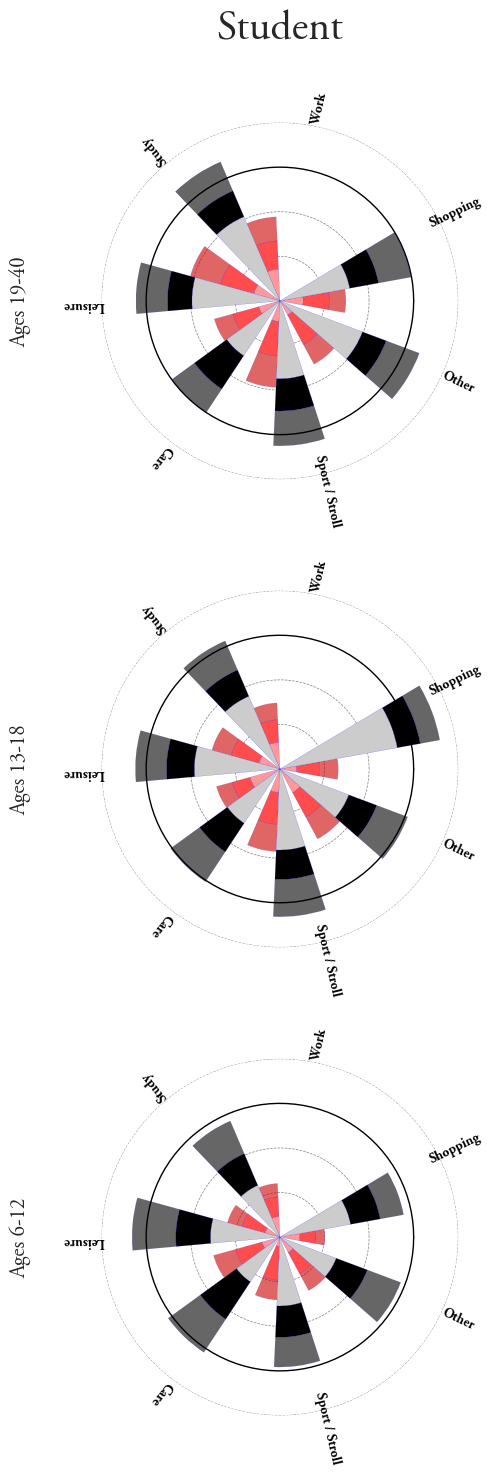

In [13]:
modos_transporte = ['Walking', 'Bus', 'Motor - Personal', 'Train']
motivos_viaje = ['Shopping', 'Work', 'Study', 'Leisure', 'Care', 'Sport / Stroll', 'Other']
activities = ['Retired', 'Worker', 'Student', 'Caretaker']
age_statuses = ['More than 65', 'Ages 41-65', 'Ages 19-40', 'Ages 13-18', 'Ages 6-12', 'Less than 5']


# Adjusted Color Scheme
colores_tonos_simplified = {
    'Walking': ['#ff9999', '#ff4d4d', '#cc0000'],  # Shades of red
    'Other Modes': ['#cccccc', 'black', '#000000']  # Shades of black
}

# Data preparation
d['TransportMode'] = d['TransportMode'].replace({'Train': 'Other Modes', 'Motor - Personal': 'Other Modes', 'Bus': 'Other Modes'})
modos_transporte_simplified = ['Walking', 'Other Modes']
d = d[d['TripPurpose'].isin(motivos_viaje)]
d = d[d['TransportMode'].isin(modos_transporte_simplified)]
d = d[d['TripDistance'] < 2]
d = d[d['Activity'].isin(activities)]

def crear_grafico(colores_tonos, df_filtered, ax):
    if df_filtered.empty:
        return  # Skip plotting if the filtered DataFrame is empty

    # Create a complete multi-index for all combinations of TripPurpose and TransportMode
    idx = pd.MultiIndex.from_product([motivos_viaje, modos_transporte_simplified], names=['TripPurpose', 'TransportMode'])
    
    # Group and calculate metrics, then reindex to include all combinations
    mean_distances_filtered = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].mean().reindex(idx, fill_value=0).reset_index()
    mean_distances_filtered['Max Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.75).reindex(idx, fill_value=0).values
    mean_distances_filtered['Min Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.25).reindex(idx, fill_value=0).values

    # Angles and colors
    num_motivos = len(motivos_viaje)
    num_bars = len(mean_distances_filtered)
    
    angle_step = 2 * np.pi / num_motivos
    bar_width = angle_step / (num_bars / num_motivos) * 0.8  # Increase spacing by reducing bar width

    # Calculate start angles and center angles for each trip purpose
    motivo_angles_start = {
        motivo: idx * angle_step
        for idx, motivo in enumerate(motivos_viaje)
    }

    motivo_angles_center = {
        motivo: (idx * angle_step) + (angle_step / 2)
        for idx, motivo in enumerate(motivos_viaje)
    }

    for i, row in mean_distances_filtered.iterrows():
        trip_purpose = row['TripPurpose']
        angle = motivo_angles_start[trip_purpose] + ((i % (num_bars // num_motivos)) * bar_width)
        modo = row['TransportMode']
        ax.bar(x=angle, height=row['Min Quartile'], width=bar_width, color=colores_tonos[modo][0], linewidth=0.1, edgecolor='b')
        ax.bar(x=angle, height=row['TripDistance'] - row['Min Quartile'], width=bar_width, bottom=row['Min Quartile'], color=colores_tonos[modo][1], linewidth=0.1, edgecolor='b')
        ax.bar(x=angle, height=row['Max Quartile'] - row['TripDistance'], width=bar_width, bottom=row['TripDistance'], color=colores_tonos[modo][2], alpha=0.6, linewidth=0.1, edgecolor='b',
               label=modo if i % (num_bars // len(modos_transporte_simplified)) == 0 else "")

    # Set the ticks and labels at the center of each segment
    ax.set_xticks([motivo_angles_center[motivo] for motivo in motivos_viaje])
    ax.set_xticklabels([])  # Remove default labels

    # Add custom labels with larger font size and adjust their positions
    label_distance = 2.2  # Distance from the center
    label_angle_adjustment = bar_width / 2  # Adjust by half the bar width
    rotation_offset = -np.radians(10)  # 10 degrees in radians

    for trip_purpose, angle in motivo_angles_center.items():
        adjusted_angle = angle + label_angle_adjustment + rotation_offset
        ax.text(adjusted_angle, label_distance, trip_purpose, horizontalalignment='center', color='black', weight='bold', rotation=np.degrees(adjusted_angle), rotation_mode='anchor', size=10, fontname='Adobe Garamond Pro')

    # Draw reference circles and labels
    for distance in np.arange(0.5, 2.5, 0.5):
        linestyle = '--'
        linewidth = 0.5
        color = 'grey'

        # Highlight the 1500 meters (1.5 km) line
        if distance == 1.5:
            linestyle = '-'
            linewidth = 1
            color = 'black'

        ax.plot(np.linspace(0, 2 * np.pi, 100), np.ones(100) * distance, color=color, linestyle=linestyle, linewidth=linewidth, zorder=0)


    # Remove radial lines
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.yaxis.set_tick_params(width=0)
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_yticklabels([])

    plt.ylim(0, 2)

def create_plots(valid_combinations, activities, age_statuses, filename, ncols):
    fig, axes = plt.subplots(len(age_statuses), len(activities), figsize=(ncols * 5, 15), subplot_kw=dict(polar=True), sharey=True)

    if len(activities) == 1:
        axes = np.expand_dims(axes, axis=-1)

    # Add the column titles
    for ax, activity in zip(axes[0], activities):
        ax.set_title(activity, pad=60, **csfont)

    # Add the row titles
    for ax, age_status in zip(axes[:, 0], age_statuses):
        ax.annotate(age_status, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 50, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='center', va='center', rotation=90, **hfont)

    for i, activity in enumerate(activities):
        for j, age_status in enumerate(age_statuses):
            ax = axes[j, i]
            if (activity, age_status) in valid_combinations:
                df_filtered = d[(d['Activity'] == activity) & (d['Age Status'] == age_status)]
                crear_grafico(colores_tonos_simplified, df_filtered, ax)
            else:
                ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Create first figure
valid_combinations_1 = [("Retired", "More than 65"), ("Retired", "Ages 41-65"), 
                        ("Worker", "More than 65"), ("Worker", "Ages 41-65"), ("Worker", "Ages 19-40"),
                        ("Caretaker", "More than 65"), ("Caretaker", "Ages 41-65"), ("Caretaker", "Ages 19-40")]

activities_1 = ['Retired', 'Worker', 'Caretaker']
age_statuses_1 = ['More than 65', 'Ages 41-65', 'Ages 19-40']
create_plots(valid_combinations_1, activities_1, age_statuses_1, r"C:\Users\katul\OneDrive\Escritorio\tripdistance_figure1_FINAL.jpg", 3)

# Create second figure
valid_combinations_2 = [("Student", "Ages 19-40"), ("Student", "Ages 13-18"), ("Student", "Ages 6-12")]
activities_2 = ['Student']
age_statuses_2 = ['Ages 19-40', 'Ages 13-18', 'Ages 6-12']
create_plots(valid_combinations_2, activities_2, age_statuses_2, r"C:\Users\katul\OneDrive\Escritorio\tripdistance_figure2_FINAL.jpg", 1)


In [14]:
def generate_complete_table(d, valid_combinations):
    """
    Generate a complete table with values for all valid combinations.

    Args:
        d (pd.DataFrame): Original dataset.
        valid_combinations (list of tuples): List of (Activity, Age Cohort) valid combinations.

    Returns:
        pd.DataFrame: Complete table for all combinations.
    """
    all_tables = []

    for activity, age_status in valid_combinations:
        # Filter data for the current activity and age cohort
        df_filtered = d[(d['Activity'] == activity) & (d['Age Status'] == age_status)]

        if df_filtered.empty:
            continue  # Skip if there are no data for the current combination

        # Create a complete multi-index for all combinations of TripPurpose and TransportMode
        idx = pd.MultiIndex.from_product([motivos_viaje, modos_transporte_simplified], names=['TripPurpose', 'TransportMode'])

        # Group and calculate metrics, then reindex to include all combinations
        mean_distances_filtered = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].mean().reindex(idx, fill_value=0).reset_index()
        mean_distances_filtered['Max Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.75).reindex(idx, fill_value=0).values
        mean_distances_filtered['Min Quartile'] = df_filtered.groupby(['TripPurpose', 'TransportMode'])['TripDistance'].quantile(0.25).reindex(idx, fill_value=0).values

        # Add columns for Activity, Age Cohort, and Elevator Sum
        mean_distances_filtered['Activity'] = activity
        mean_distances_filtered['Age Cohort'] = age_status
        mean_distances_filtered['Elevator Sum'] = df_filtered['ELE_G_POND'].sum()

        # Rename columns for clarity
        mean_distances_filtered.rename(columns={
            'TripPurpose': 'Trip Purpose',
           
            'TransportMode': 'Transport Mode',
            'TripDistance': 'Mean Distance'
        }, inplace=True)

        # Reorder columns for clarity
        mean_distances_filtered = mean_distances_filtered[['Activity', 'Age Cohort', 'Trip Purpose', 'Transport Mode', 'Mean Distance', 'Min Quartile', 'Max Quartile', 'Elevator Sum']]

        # Append to the list of all tables
        all_tables.append(mean_distances_filtered)

    # Concatenate all individual tables into a single DataFrame
    complete_table = pd.concat(all_tables, ignore_index=True)

    return complete_table

# Generate the complete table for all valid combinations
valid_combinations = [
    ("Retired", "More than 65"), ("Retired", "Ages 41-65"),
    ("Worker", "More than 65"), ("Worker", "Ages 41-65"), ("Worker", "Ages 19-40"),
    ("Caretaker", "More than 65"), ("Caretaker", "Ages 41-65"), ("Caretaker", "Ages 19-40"),
    ("Student", "Ages 19-40"), ("Student", "Ages 13-18"), ("Student", "Ages 6-12")
]

# Generate the table
complete_table = generate_complete_table(d, valid_combinations)

# Print the table to copy and paste
print(complete_table.to_string(index=False, float_format="{:.2f}".format))


 Activity   Age Cohort   Trip Purpose Transport Mode  Mean Distance  Min Quartile  Max Quartile  Elevator Sum
  Retired More than 65       Shopping        Walking           0.44          0.17          0.60     634782.99
  Retired More than 65       Shopping    Other Modes           1.18          0.80          1.61     634782.99
  Retired More than 65           Work        Walking           0.00          0.00          0.00     634782.99
  Retired More than 65           Work    Other Modes           0.00          0.00          0.00     634782.99
  Retired More than 65          Study        Walking           0.00          0.00          0.00     634782.99
  Retired More than 65          Study    Other Modes           0.00          0.00          0.00     634782.99
  Retired More than 65        Leisure        Walking           0.54          0.21          0.74     634782.99
  Retired More than 65        Leisure    Other Modes           1.22          0.81          1.63     634782.99
  Retired 

In [15]:
d.columns

Index(['ID_HOGAR', 'ID_IND', 'ID_VIAJE', 'ID_ETAPA', 'Gender', 'Age',
       'ELE_G_POND', 'Foreign', 'C5CAM', 'HasLicense', 'EducationLevel',
       'Activity', 'C9PROF', 'C10SECTOR', 'TravelCard', 'C14ABONO', 'DDIA',
       'DMES', 'DANNO', 'DayOfWeek', 'DNOVIAJO', 'C11ZT1259', 'C12ZT1259',
       'PRM', 'TIPO_ENCUESTA', 'CODMUNI', 'NOMMUNI', 'CODPROV', 'NOMPROV',
       'ZT1259', 'CZ208', 'ELE_HOGAR_NUEVO', 'A1PER', 'A2PER4', 'B1NVE',
       'V1B11TIPO', 'V1B12CARB', 'V1B13EST', 'V2B11TIPO1', 'V2B12CARB1',
       'V2B13EST1', 'V3B11TIPO1', 'V3B12CARB1', 'V3B13EST1', 'V4B11TIPO1',
       'V4B12CARB1', 'V4B13EST1', 'V5B11TIPO1', 'V5B12CARB1', 'V5B13EST1',
       'HouseholdSize', 'TripsHousehold', 'EMODO', 'EMODO1', 'TransportMode',
       'MODO', 'ELINEAEMPRESA_ORIGINAL', 'ESUBIDA', 'ESUBIDA_cod', 'EBAJADA',
       'EBAJADA_cod', 'ETITULO', 'EESTACIONA', 'EOCUPACION', 'ETDESPH',
       'COD_MUN_PARADA', 'ELE_G_POND_Esc2', 'VORI', 'StartTime', 'VDES',
       'EndTime', 'Frequency', 'Ha

C:\Users\katul\AppData\Local\Temp\ipykernel_9388\549429959.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\549429959.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\549429959.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\549429959.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local

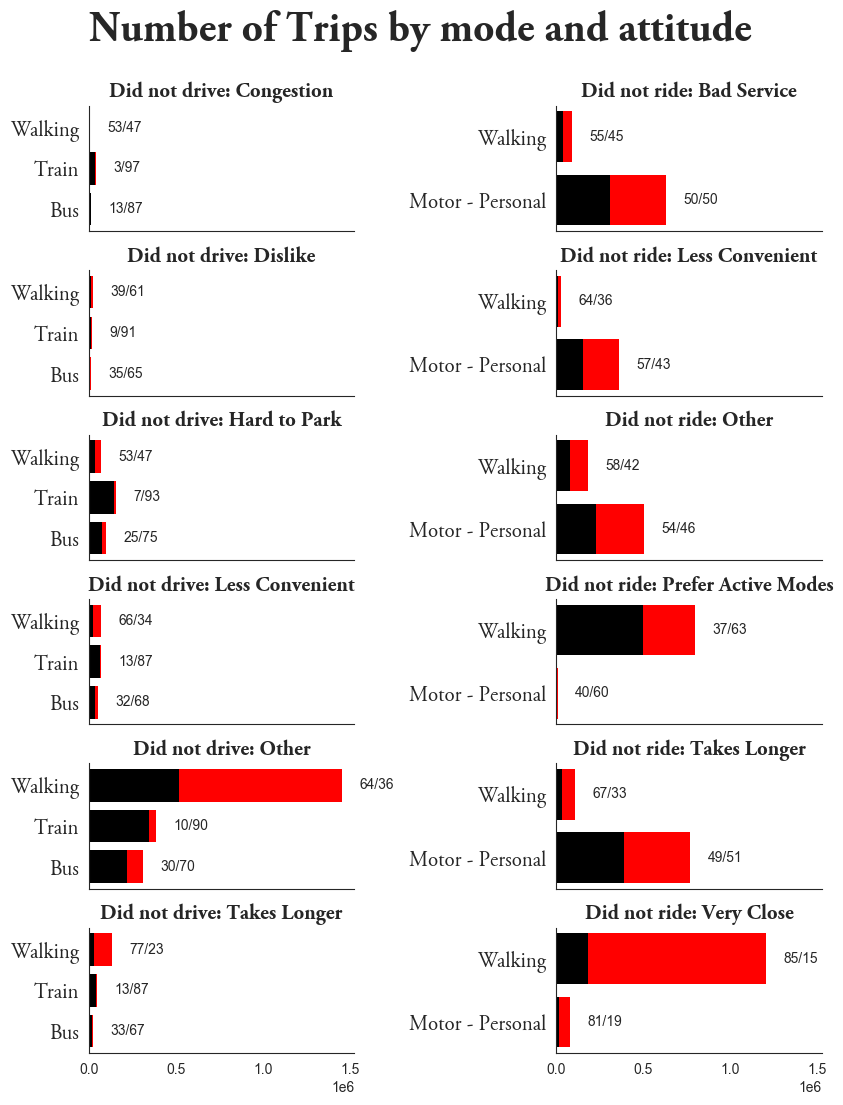

In [16]:

noprivate = sorted(df['NoPrivate'].dropna().unique())
nopublic = sorted(df['NoPublic'].dropna().unique())

fig, axs = plt.subplots(6, 2, figsize=(8.5, 11),sharex=True) #, gridspec_kw={'height_ratios': [2, 2, 2, 4,5,6,7]},sharex=True) 


#fig.add_gridspec(nrows=7, ncols=2, height_ratios=[2, 2, 2, 4,5,6,7])

fig.suptitle('Number of Trips by mode and attitude', fontweight="bold", y=1, **csfont)  # Title

colors = {"Yes": "red", "No": "black"}

for i in range(0,6,1):

    for n in [0,1]:

        if n==0:
            r = 'Did not drive:'
            rs = noprivate[i]
            d = df[df['NoPrivate'] == rs]
            d = d[~d['TransportMode'].isin(['Motor - Shared','Other','Cycling'])]
            d = d[~d['TransportMode'].isin(['Motor - Personal','Motor - Shared'])].groupby(['TransportMode','Trip15'])['ELE_G_POND'].sum().unstack().fillna(0)
            
            #print(noprivate[i])
            #print(d)
        else:
            rs = nopublic[i]
            d = df[df['NoPublic'] == rs]
            d = d[~d['TransportMode'].isin(['Motor - Shared','Other','Cycling'])]
            d = d.groupby(['TransportMode','Trip15'])['ELE_G_POND'].sum().unstack().fillna(0)
            
            #d = d[~d['TransportMode'].isin(['Train','Bus'])].groupby(['TransportMode','Trip15']).sum()['ELE_G_POND']
            r = 'Did not ride:'
            #print(nopublic[i])
            #print(d)
        
        #d['Total'] = d.sum()
        #d = d.sort_values(by='Total', ascending=False).drop(columns='Total')
        a = axs[i][n]

        bottom = [0] * len(d)
        #print(d)
        for category in d.columns:
            a.barh(d.index, d[category], color=colors[category], edgecolor='none', label=category, left=bottom)
            bottom = bottom + d[category].values

        for j, (index, row) in enumerate(d.iterrows()):
            p15 = row['Yes']
            plt_ = row['No']
            total = p15 + plt_
            p15_pct = int(round((p15 / total) * 100))
            plt_pct = int(round((plt_ / total) * 100))
            label = f"{p15_pct}/{plt_pct}"
            x_pos = row['Yes'] + row['No']
            a.text(x_pos+100000, j, label,va='center',ha='left')
        
        a.set_title(f"{r} {rs}", fontweight="bold",**hfont)  # Title
        #a.set_xlabel('ELE_G_POND')
        a.set_ylabel('')
        a.set_yticklabels(d.index, rotation=0,**hfont)
        a.set_xlabel('') 
        #a.axis('off')
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\attitudinal.jpg")
plt.show()


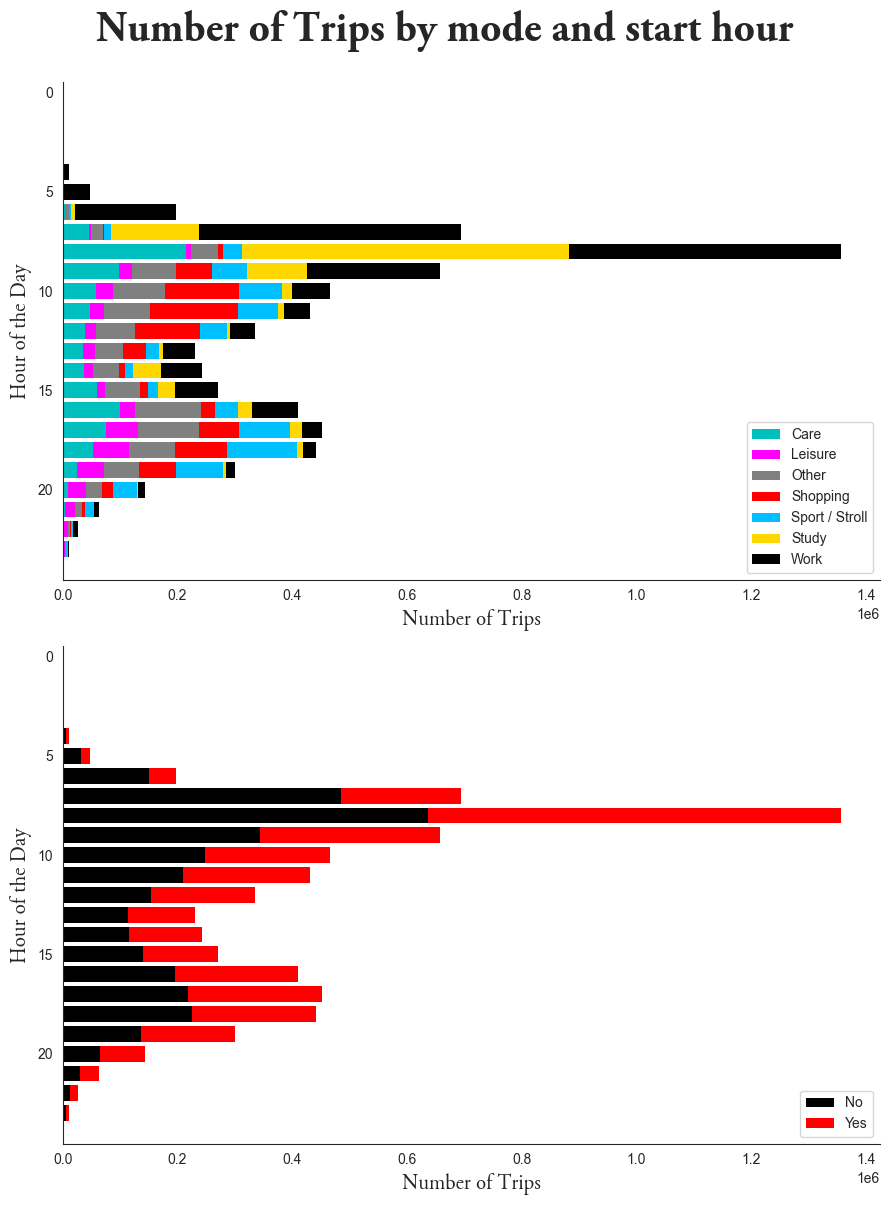

In [17]:
fig, axs = plt.subplots(2,1,figsize=(9,12))
fig.suptitle('Number of Trips by mode and start hour', fontweight="bold", y=1, **csfont)  # Title

colors = {'Shopping':'r', 'Work':'k', 'Study':'gold', 'Leisure':'magenta', 'Care':'c', 'Sport / Stroll':'deepskyblue','Other':'grey'}
ax = axs[0]

d = df[~df['TripPurpose'].isna()].sort_values(by=['StartTime','TripPurpose'],ascending=True).groupby(['StartTime','TripPurpose'])['ELE_G_POND'].sum().unstack().fillna(0)
d = d[d.index != 0.0]

bottom = [0] * len(d)

for category in d.columns:

    ax.barh(d.index, d[category], color=colors[category], edgecolor='none', label=category, left=bottom)
    bottom = bottom + d[category].values

ax.invert_yaxis()
#a.set_xlabel('ELE_G_POND')
ax.set_ylabel('Hour of the Day',**hfont)
#ax.set_yticklabels(d.index,**hfont)
ax.set_xlabel('Number of Trips',**hfont) 
#a.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc="lower right")

colors = {'Yes':'r', 'No':'k'}
ax = axs[1]


d = df[~df['Trip15'].isna()].sort_values(by=['StartTime','Trip15'],ascending=True).groupby(['StartTime','Trip15'])['ELE_G_POND'].sum().unstack().fillna(0)
d = d[d.index != 0.0]

bottom = [0] * len(d)

for category in d.columns:

    ax.barh(d.index, d[category], color=colors[category], edgecolor='none', label=category, left=bottom)
    bottom = bottom + d[category].values

ax.invert_yaxis()
#a.set_xlabel('ELE_G_POND')
ax.set_ylabel('Hour of the Day',**hfont)
#ax.set_yticklabels(d.index,**hfont)
ax.set_xlabel('Number of Trips',**hfont) 
#a.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc="lower right")


plt.tight_layout()
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\timegeography.jpg")
plt.show()


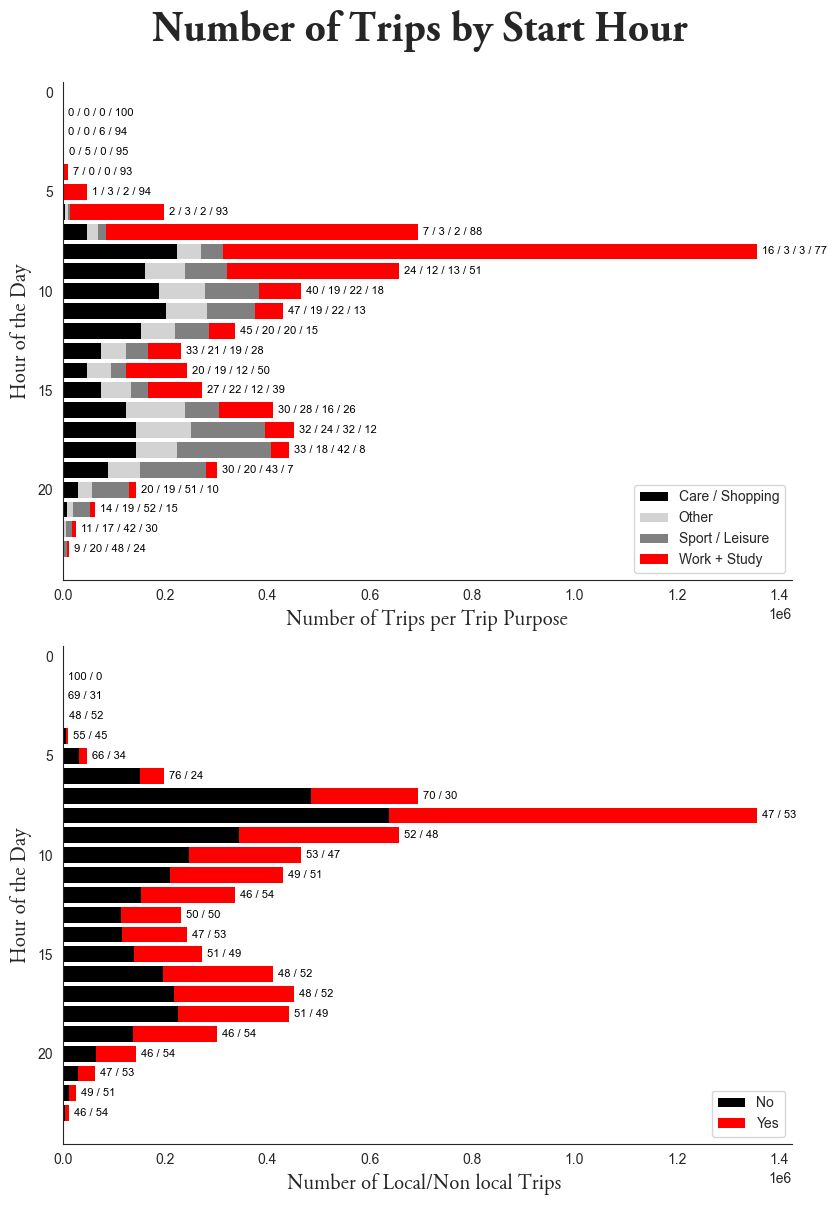

In [18]:
import matplotlib.pyplot as plt

def plot_trip_data_with_proportions(ax, data, colors, ylabel, xlabel, legend_loc="lower right"):
    bottom = [0] * len(data)
    an_offset = 10000  # Increased offset to move the labels further right

    for category in data.columns:
        ax.barh(data.index, data[category], color=colors[category], edgecolor='none', label=category, left=bottom)
        bottom = bottom + data[category].values
    
    # Add proportion labels further past the end of each bar
    for i, (index, row) in enumerate(data.iterrows()):
        proportions = (row / row.sum() * 100).round().astype(int)  # Calculate proportions as integers
        label = " / ".join(map(str, proportions))  # Format the label
        ax.text(row.sum() + an_offset, index, label, va='center', ha='left', fontsize=8, color='black')  # Position at end

    ax.invert_yaxis()
    ax.set_ylabel(ylabel, **hfont)
    ax.set_xlabel(xlabel, **hfont)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc=legend_loc)

fig, axs = plt.subplots(2, 1, figsize=(8.5, 12))
fig.suptitle('Number of Trips by Start Hour', fontweight="bold", y=1, **csfont)

# First subplot for merged TripPurpose categories, including Other
df['MergedPurpose'] = df['TripPurpose'].replace({
    'Work': 'Work + Study', 'Study': 'Work + Study',
    'Sport / Stroll': 'Sport / Leisure', 'Leisure': 'Sport / Leisure',
    'Care': 'Care / Shopping', 'Shopping': 'Care / Shopping'
})

colors_merged_purpose = {
    'Work + Study': 'red',
    'Sport / Leisure': 'grey',
    'Care / Shopping': 'black',
    'Other': 'lightgrey'
}

data_merged_purpose = df[~df['MergedPurpose'].isna()].sort_values(by=['StartTime', 'MergedPurpose'], ascending=True)\
                      .groupby(['StartTime', 'MergedPurpose'])['ELE_G_POND'].sum().unstack().fillna(0)
data_merged_purpose = data_merged_purpose[data_merged_purpose.index != 0.0]

plot_trip_data_with_proportions(axs[0], data_merged_purpose, colors_merged_purpose, ylabel='Hour of the Day', xlabel='Number of Trips per Trip Purpose')

# Second subplot for Trip15
colors_trip_15 = {'Yes': 'r', 'No': 'k'}
data_trip_15 = df[~df['Trip15'].isna()].sort_values(by=['StartTime', 'Trip15'], ascending=True)\
                .groupby(['StartTime', 'Trip15'])['ELE_G_POND'].sum().unstack().fillna(0)
data_trip_15 = data_trip_15[data_trip_15.index != 0.0]

plot_trip_data_with_proportions(axs[1], data_trip_15, colors_trip_15, ylabel='Hour of the Day', xlabel='Number of Local/Non local Trips ')

plt.tight_layout()
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\timegeography.jpg")
plt.show()


In [19]:
d = df.copy()

In [20]:
household_activity = pd.merge(pd.concat(
[d.groupby(['HouseholdStructure','Household15min']).count()['ID_HOGAR'].rename('type15').reset_index().set_index('HouseholdStructure'),
d.groupby(['HouseholdStructure','Household30min']).count()['ID_HOGAR'].rename('type30').reset_index().set_index('HouseholdStructure')],axis=1),
d.groupby('HouseholdStructure').count()['ID_HOGAR'].rename('totalhouseholds'), left_index=True, right_index=True
)

household_activity['p15'] = round(household_activity.type15 * 100 / household_activity.totalhouseholds,0).astype(int)
household_activity['p30'] = round(household_activity.type30 * 100 / household_activity.totalhouseholds,0).astype(int)
household_activity.reset_index(inplace=True)


In [21]:
household_activity

HouseholdStructure Household15min  type15 Household30min  type30  \
0               Children             No    1476             No     904   
1               Children            Yes     284            Yes     856   
2      Full-Time Workers             No   34735             No   24884   
3      Full-Time Workers            Yes    4830            Yes   14681   
4                  Other             No    6468             No    4017   
5                  Other            Yes    2658            Yes    5109   
6               Retirees             No   14556             No    9527   
7               Retirees            Yes    5782            Yes   10811   
8   Students (Age 13–18)             No   11262             No    7894   
9   Students (Age 13–18)            Yes    1049            Yes    4417   
10   Students (Age 6–12)             No   12808             No    8658   
11   Students (Age 6–12)            Yes    1559            Yes    5709   
12    Students (age 19+)             No    3514             No    2104   
13    Students (age 19+)            Yes    1104            Yes    2514   

    totalhouseholds  p15  p30  
0              1760   84   51  
1              1760   16   49  
2             39565   88   63  
3             39565   12   37  
4              9126   71   44  
5              9126   29   56  
6             20338   72   47  
7             20338   28   53  
8             12311   91   64  
9             12311    9   36  
10            14367   89   60  
11            14367   11   40  
12             4618   76   46  
13             4618   24   54

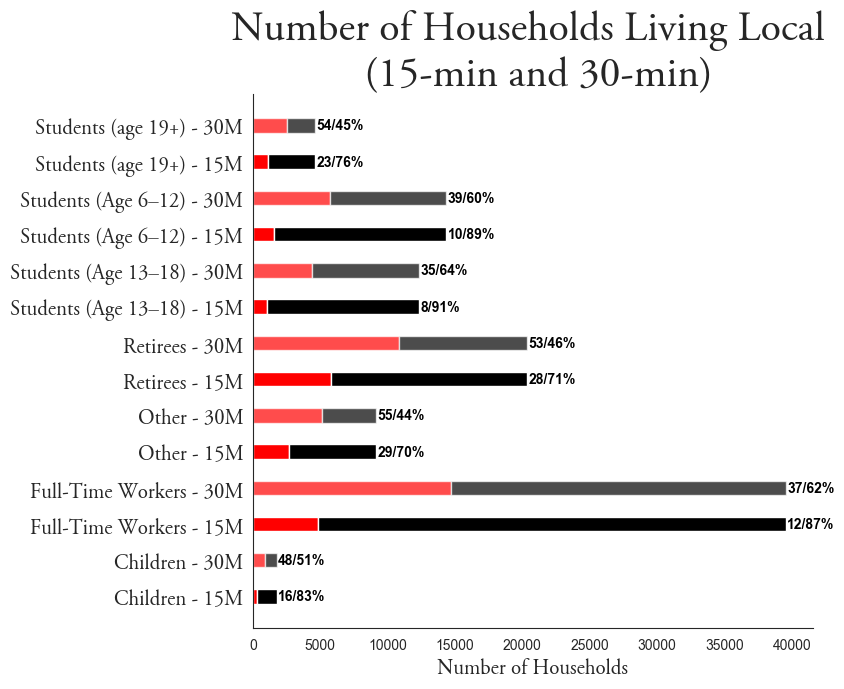

In [22]:
# Adjusting the placement of text labels to the right end of each bar with black text color
ages = ['Children', 'Full-Time Workers', 'Other', 'Retirees', 'Students (Age 13–18)', 'Students (Age 6–12)', 'Students (age 19+)']
household_activity_15min_yes = household_activity[household_activity['Household15min'] == 'Yes']['type15'].values
household_activity_15min_no = household_activity[household_activity['Household15min'] == 'No']['type15'].values
household_activity_30min_yes = household_activity[household_activity['Household30min'] == 'Yes']['type30'].values
household_activity_30min_no = household_activity[household_activity['Household30min'] == 'No']['type30'].values

fig, ax = plt.subplots(figsize=(8.5, 7))
width = 0.4  # Width of the bar
age_indices = [i * 2 for i in range(len(ages))] + [i * 2 + 1 for i in range(len(ages))]
age_labels = [f"{age} - 15M" for age in ages] + [f"{age} - 30M" for age in ages]
# Plotting the stacked bars for each age group with text labels at the right end
for i in range(len(ages)):
    # 15-min data
    red_value_15min = household_activity_15min_yes[i]
    black_value_15min = household_activity_15min_no[i]
    total_15min = red_value_15min + black_value_15min
    
    ax.barh(i * 2, red_value_15min, color='red', height=width)
    ax.barh(i * 2, black_value_15min, left=red_value_15min, color='black', height=width)
    
    # Display text at the end of each 15-min bar
    ax.text(red_value_15min + black_value_15min + 100, i * 2, f'{int(red_value_15min / total_15min * 100)}/{int(black_value_15min / total_15min * 100)}%', 
            va='center', ha='left', color='black', fontweight='bold')
    
    # 30-min data
    red_value_30min = household_activity_30min_yes[i]
    black_value_30min = household_activity_30min_no[i]
    total_30min = red_value_30min + black_value_30min
    
    ax.barh(i * 2 + 1, red_value_30min, color='red', height=width, alpha=0.7)
    ax.barh(i * 2 + 1, black_value_30min, left=red_value_30min, color='black', height=width, alpha=0.7)
    
    # Display text at the end of each 30-min bar
    ax.text(red_value_30min + black_value_30min + 100, i * 2 + 1, f'{int(red_value_30min / total_30min * 100)}/{int(black_value_30min / total_30min * 100)}%', 
            va='center', ha='left', color='black', fontweight='bold')

# Adding labels and title
ax.set_yticks(age_indices)
ax.set_yticklabels(age_labels,  **hfont)
ax.set_xlabel('Number of Households', **hfont)
ax.set_title('Number of Households Living Local \n (15-min and 30-min)', **csfont)

#csfont = {'fontname':'Adobe Garamond Pro','fontsize':30}
#hfont = {'fontname':'Adobe Garamond Pro','fontsize':15}

# Removing unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\household structure.jpg")
plt.show()


C:\Users\katul\AppData\Local\Temp\ipykernel_9388\2119438160.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(d,x='p30',y=hou,ax=ax,width=0.5,palette=palette)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\2119438160.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(d[hou], rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\2119438160.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(d,x='p15',y=hou,ax=ax,width=0.5,palette=palette)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\2119438160.py:25: UserWarning: set_ticklabels() should only be used with a fixed nu

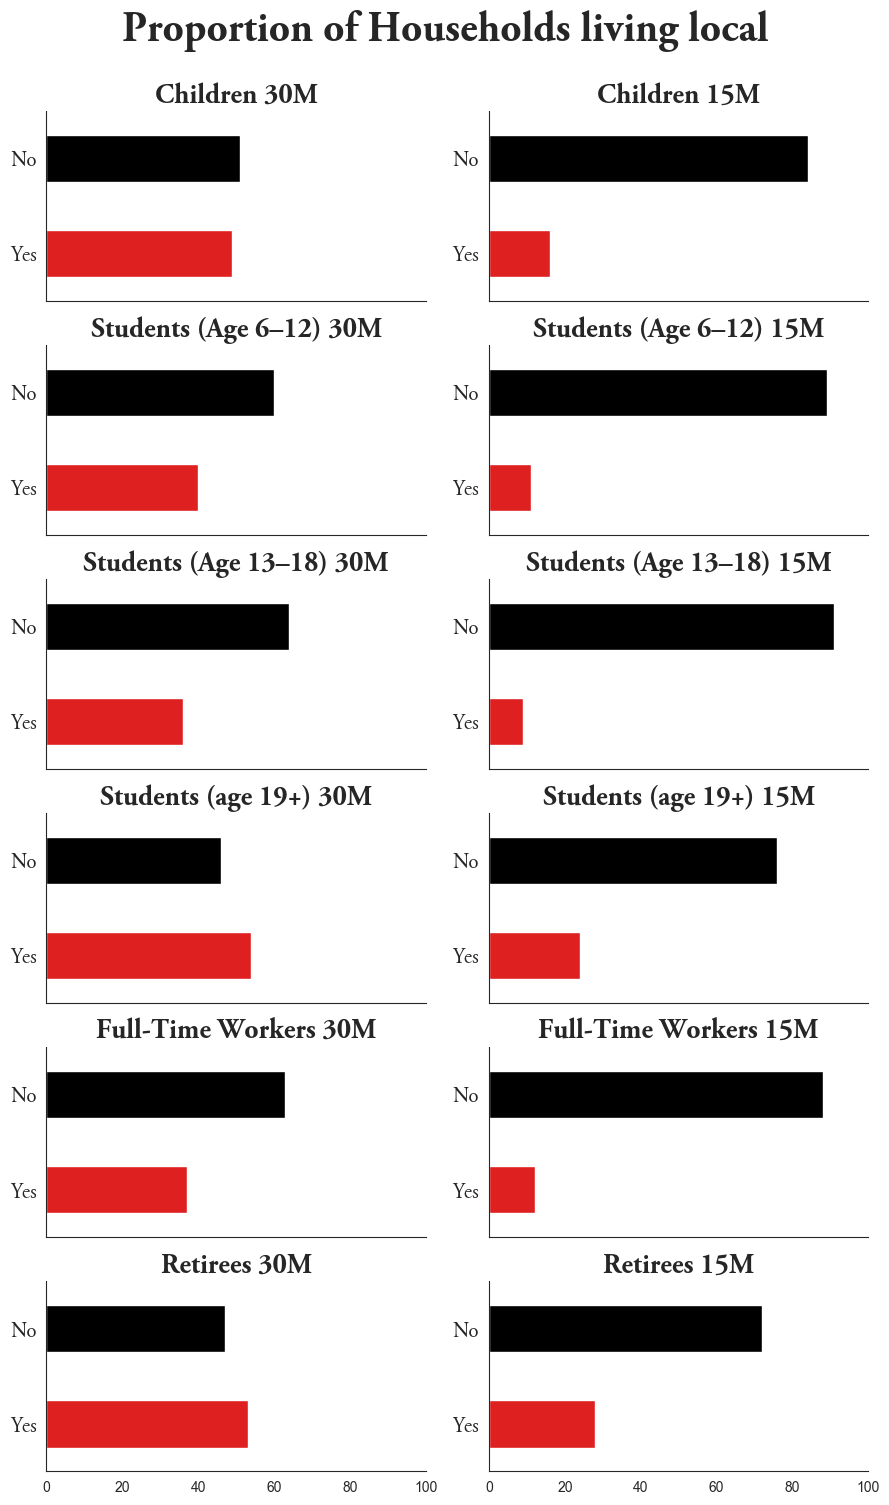

In [23]:
ages = ['Children', 'Students (Age 6–12)', 'Students (Age 13–18)', 'Students (age 19+)', 'Full-Time Workers', 'Retirees']
#fig.clf()
palette = {"Yes": "red", "No": "black"}

fig, axs = plt.subplots(6,2,figsize = (9,15),sharex=True)

fig.suptitle('Proportion of Households living local',**csfont, fontweight="bold",y=1) # Title

for i,a in enumerate(ages):
    for p, hou in enumerate(['Household15min','Household30min']):
        d = household_activity[household_activity['HouseholdStructure']==a]
        ax = axs[i,p]
        if p == 1:
            sn.barplot(d,x='p15',y=hou,ax=ax,width=0.5,palette=palette)
            ax.set_title(f"{a} 15M", fontname='Adobe Garamond Pro',fontsize=20,fontweight="bold") # Y label
            #ax.yaxis.set_label_text("")
            #ax.set_xlabel('') 
            #ax.set_xlim([0, 100])
        else:
            sn.barplot(d,x='p30',y=hou,ax=ax,width=0.5,palette=palette)
            ax.set_title(f"{a} 30M", fontname='Adobe Garamond Pro',fontsize=20, fontweight="bold") # Y label
        ax.yaxis.set_label_text("")
        ax.set_xlabel('') 
        ax.set_xlim([0, 100])
        ax.set_yticklabels(d[hou], rotation=0,**hfont)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        


plt.tight_layout()
plt.show()

# Plot Density

In [24]:
gdf_ine = gpd.read_file(r"G:\Mi unidad\walknet_datalake\sources\ine_geo\level1\level1_ine_geo_2018.gpkg")
muni_ref = gdf_ine[(gdf_ine['boundary_type'] == "municipality")&(gdf_ine['municipality_code'].isin(["28005", "28006", "28007", "28022", "28026", "28045", "28049", "28058", "28065", "28073", "28074", "28080", "28084", "28092", "28104", "28106", "28113", "28115", "28127", "28130", "28134", "28148", "28167", "28176", "28177", "28181", "28903", "28079","28123","28903"]))]
muni_ref['geometry'] = muni_ref['geometry'].boundary

c:\Documents\Github\pw_sources\env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
gdf = gpd.read_file(r"G:\Mi unidad\walknet_datalake\sources\edm_geo\level0\ZonificacionZT1259.shp")
gdf = gdf[gdf['ZT1259'].str.startswith(("005", "006", "007", "022", "026", "045", "049", "058", "065", "073", "074", "080", "084", "092", "104", "106", "113", "115", "127", "130", "134", "148", "167", "176", "177", "181", "184", "079","123","903"))]
gdf = gdf.to_crs(25830)
gdf['centroid'] = gdf.geometry.representative_point()

c:\Documents\Github\pw_sources\env\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: G:\Mi unidad\walknet_datalake\sources\edm_geo\level0\ZonificacionZT1259.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [26]:
gdf['CODMUNI'] = gdf['ZT1259'].str.split("-").str[0]

In [27]:
env = pd.read_csv(r"G:\Mi unidad\walknet_datalake\extractions\density_new.csv")


In [28]:
import os
p = r"G:\Mi unidad\walknet_datalake\sources\catastro\level2"

urban = pd.concat([pd.read_csv(os.path.join(p,f),sep=";") for f in os.listdir(p) if "_polygon" in f])

In [29]:
from shapely import wkt
urban.geometry = urban.geometry.apply(wkt.loads)
urban = gpd.GeoDataFrame(urban,geometry='geometry',crs=25830)


In [30]:
merged = pd.merge( env[env['boundary_type']!='tz'].set_index('boundary_id'),
gdf_ine[['boundary_code','geometry']].set_index('boundary_code'), left_index=True, right_index=True)
merged = gpd.GeoDataFrame(merged,geometry='geometry',crs=25830)


In [31]:
inter = gpd.overlay(urban, merged.reset_index(), how='intersection')
inter['urban_area'] = inter.geometry.area

In [32]:
inter

id id_class               category  provider  \
0     28005-1-0     aois  land use - urban area         1   
1     28005-1-0     aois  land use - urban area         1   
2     28005-1-0     aois  land use - urban area         1   
3     28005-1-0     aois  land use - urban area         1   
4     28005-1-1     aois  land use - urban area         1   
...         ...      ...                    ...       ...   
5108  28123-1-0     aois  land use - urban area         1   
5109  28123-1-0     aois  land use - urban area         1   
5110  28123-1-0     aois  land use - urban area         1   
5111  28123-1-0     aois  land use - urban area         1   
5112  28123-1-0     aois  land use - urban area         1   

                                data       index boundary_type  housing  \
0     {'area': '47695.551748472986'}  2800504015  census_tract      402   
1     {'area': '47695.551748472986'}     2800504      district    14491   
2     {'area': '47695.551748472986'}       28005  municipality    79591   
3     {'area': '47695.551748472986'}          28      province  2440367   
4      {'area': '102415.3528082172'}  2800504015  census_tract      402   
...                              ...         ...           ...      ...   
5108  {'area': '14217919.304079283'}     2807919      district    31473   
5109  {'area': '14217919.304079283'}     2812301      district    32880   
5110  {'area': '14217919.304079283'}       28123  municipality    32880   
5111  {'area': '14217919.304079283'}       28079  municipality  1488637   
5112  {'area': '14217919.304079283'}          28      province  2440367   

      population  care_area  leisure_area  retail_area  sport_area  \
0           1407       2800             0            0          57   
1          44108     151793         60995        79497      141813   
2         222294     220936         96131       567299      402259   
3        6355247    5887181       1339057     14996600     7663864   
4           1407       2800             0            0          57   
...          ...        ...           ...          ...         ...   
5108       85067      40872         13819       119998       68766   
5109      104163      17083             0       222745      205942   
5110      104163      17083             0       222745      205942   
5111     3755236    3737689       1069449      8958513     3376925   
5112     6355247    5887181       1339057     14996600     7663864   

      parcel_area  parcel_built_area  parcel_built_ag  \
0         3879464            5222480          4147899   
1       268347539          749707308        537386419   
2       704765927         1764731965       1309086396   
3     26309161010        67126633410      48529077044   
4         3879464            5222480          4147899   
...           ...                ...              ...   
5108    509573268         1766660859       1297078902   
5109    804562337         2294559521       1675946726   
5110    804562337         2294559521       1675946726   
5111  10161447605        33840157387      24752437261   
5112  26309161010        67126633410      48529077044   

                                               geometry    urban_area  
0     POLYGON ((468216.226 4484952.412, 468142.224 4...  4.769555e+04  
1     POLYGON ((468216.226 4484952.412, 468142.224 4...  4.769555e+04  
2     POLYGON ((468216.226 4484952.412, 468142.224 4...  4.769555e+04  
3     POLYGON ((468216.226 4484952.412, 468142.224 4...  4.769555e+04  
4     POLYGON ((468622.294 4485153.548, 468648.859 4...  1.024154e+05  
...                                                 ...           ...  
5108  MULTIPOLYGON (((453021.024 4467442.932, 453021...  7.343097e+03  
5109  POLYGON ((453728.156 4469908.605, 454180.089 4...  1.421058e+07  
5110  POLYGON ((453728.156 4469908.605, 454180.089 4...  1.421058e+07  
5111  MULTIPOLYGON (((453021.024 4467442.932, 453021...  7.343097e+03  
5112  POLYGON ((453728.156 4469908.605, 454180.089 4...  1.42

In [33]:
merged['urban_area'] = merged.index.map({k:v for k,v in inter.groupby('index')['urban_area'].sum().to_dict().items() if k})
merged['NetDensity'] = merged['population'] / (merged['urban_area'] / 10000)
merged['NetDensity'].fillna(0,inplace=True)
merged['NetDensity'] = merged['NetDensity'].astype(int)
merged = merged[merged['NetDensity']>-1]
merged['boundary_type'].unique()

C:\Users\katul\AppData\Local\Temp\ipykernel_9388\701168946.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['NetDensity'].fillna(0,inplace=True)


array(['census_tract', 'district', 'municipality', 'province'],
      dtype=object)

In [34]:
merged_tz = pd.merge( env[env['boundary_type']=='tz'].set_index('boundary_id'),
gdf[['ZT1259','geometry']].set_index('ZT1259'), left_index=True, right_index=True)

merged_tz = gpd.GeoDataFrame(merged_tz,geometry='geometry',crs=25830)


In [35]:
inter = gpd.overlay(urban, merged_tz.reset_index(), how='intersection')
inter['urban_area'] = inter.geometry.area

In [36]:
merged_tz['urban_area'] = merged_tz.index.map(inter.groupby('index')['urban_area'].sum().to_dict())


In [37]:
merged_tz['NetDensity'] = merged_tz['population'] / (merged_tz['urban_area'] / 10000)
merged_tz['NetDensity'] = merged_tz['NetDensity'].fillna(0).astype(int)
merged_tz = merged_tz[merged_tz['NetDensity']>0]


In [38]:
import numpy as np
def quantiles(data:pd.Series):
    return pd.qcut(data, np.linspace(0,1,5), labels= np.linspace(0.25,1,4), duplicates='drop')


In [39]:
merged_tz.sort_values(by='NetDensity')

boundary_type  housing  population  care_area  leisure_area  \
007-001B              tz       12          36       1141             0   
079-08-188            tz       17          43        911             0   
115-019               tz       37         123      32225             0   
079-19-536            tz       70         239       6145             0   
074-037               tz       34         102          0             0   
...                  ...      ...         ...        ...           ...   
079-02-036            tz     5463       12644        660             0   
079-01-020            tz     6957       13857          0          2718   
079-08-183            tz     5915       13972          0             0   
079-08-178            tz     4345        9468          0             0   
045-007               tz      346        1384          0             0   

            retail_area  sport_area  parcel_area  parcel_built_area  \
007-001B              0        5477      1193397            1372201   
079-08-188        12317        1322      2075508            8713988   
115-019             535           0     10260817           10957459   
079-19-536         6707          59      6556700            4907506   
074-037             162           0     26105423           54744405   
...                 ...         ...          ...                ...   
079-02-036        28912         908      9612442           71203608   
079-01-020        48604         325      5029849           26590161   
079-08-183        21393        4233      2809005           22152760   
079-08-178        11698           0      3077410           25166409   
045-007               0        2525      3793518            1236098   

            parcel_built_ag  \
007-001B            1061558   
079-08-188          5939332   
115-019             7543523   
079-19-536          4248183   
074-037            47655930   
...                     ...   
079-02-036         56920757   
079-01-020         21104231   
079-08-183         20336388   
079-08-178         21217692   
045-007             1080999   

                                                     geometry    urban_area  \
007-001B    POLYGON ((429044.589 4472125.893, 429081.264 4...  3.071750e+05   
079-08-188  POLYGON ((441853.317 4482478.035, 441849.542 4...  2.907295e+05   
115-019     POLYGON ((432901.155 4473711.836, 432830.252 4...  6.751318e+05   
079-19-536  POLYGON ((450512.848 4471140.501, 450525.548 4...  2.072950e+06   
074-037     POLYGON ((432507.671 4462479.193, 432456.408 4...  1.008790e+06   
...                                                       ...           ...   
079-02-036  POLYGON ((440721.57 4471703.746, 440721.576 44...  1.858498e+05   
079-01-020  POLYGON ((440659.754 4473778.401, 440653.686 4...  2.028243e+05   
079-08-183  POLYGON ((439722.663 4480755.167, 439722.775 4...  1.963474e+05   
079-08-178  POLYGON ((439336.256 4480820.084, 439340.675 4...  1.296812e+05   
045-007     POLYGON ((436405.834 4501833.109, 436390.781 4...  1.119661e+04   

            NetDensity  
007-001B             1  
079-08-188           1  
115-019              1  
079-19-536           1  
074-037              1  
...                ...  
079-02-036         680  
079-01-020         683  
079-08-183         711  
079-08-178         730  
045-007           1236  

[753 rows x 13 columns]

In [40]:
merged_tz['NetDensityL'] = quantiles(merged_tz['NetDensity'])

In [41]:
for a in ['municipality','district','census_tract']:
    merged.loc[(merged['boundary_type']==a)&(merged['NetDensity']>0),'NetDensityL'] = quantiles(merged[merged['boundary_type']==a]['NetDensity'])


In [42]:
merged

boundary_type  housing  population  care_area  leisure_area  \
2800601041  census_tract      784        2899         85             0   
2807910103  census_tract      549        1269          0             0   
2807909077  census_tract      549        1410          0             0   
2807915038  census_tract      866        2113          0             0   
2802201001  census_tract      756        2219         81             0   
...                  ...      ...         ...        ...           ...   
28005       municipality    79591      222294     220936         96131   
28049       municipality    31667       90234     148957         12243   
28176       municipality     8294       31079      29665             0   
28074       municipality    78213      210014     161995         22681   
28              province  2440367     6355247    5887181       1339057   

            retail_area  sport_area  parcel_area  parcel_built_area  \
2800601041          248        1642     23119255           23220461   
2807910103         1769           0       401844            1700811   
2807909077         2766           0      2147339            5956616   
2807915038         4391           0       965235            5361388   
2802201001         7682         883      2008315            8412270   
...                 ...         ...          ...                ...   
28005            567299      402259    704765927         1764731965   
28049            181308      114838    228382149          939422612   
28176                 0       85596    190001859          135546824   
28074            557634      250068   1271502016         2521882595   
28             14996600     7663864  26309161010        67126633410   

            parcel_built_ag  \
2800601041         19191635   
2807910103          1337494   
2807909077          4381783   
2807915038          3751939   
2802201001          5097522   
...                     ...   
28005            1309086396   
28049             630552551   
28176             104111889   
28074            1973023576   
28              48529077044   

                                                     geometry    urban_area  \
2800601041  MULTIPOLYGON (((445985.83 4486527.997, 445978....  3.258192e+05   
2807910103  MULTIPOLYGON (((436385.642 4471579.043, 436223...  2.385403e+04   
2807909077  MULTIPOLYGON (((433948.173 4478959.111, 433948...  5.207770e+04   
2807915038  MULTIPOLYGON (((444875.648 4475804.456, 444880...  4.044519e+04   
2802201001  MULTIPOLYGON (((425710.778 4473231.735, 425708...  4.816862e+04   
...                                                       ...           ...   
28005       MULTIPOLYGON (((470479.308 4478141.515, 470474...  3.158723e+07   
28049       MULTIPOLYGON (((453316.627 4473630.312, 453300...  9.787415e+06   
28176       MULTIPOLYGON (((419227.63 4476886.109, 419221....  9.924390e+06   
28074       MULTIPOLYGON (((436703.064 4463219.174, 436634...  2.235812e+07   
28          MULTIPOLYGON (((415647.54 4451507.876, 415454....  7.019435e+08   

            NetDensity NetDensityL  
2800601041          88        0.25  
2807910103         531        1.00  
2807909077         270        0.50  
2807915038         522        1.00  
2802201001         460        0.75  
...                ...         ...  
28005               70        0.75  
28049               92        0.75  
28176               31        0.25  
28074               93        1.00  
28                  90         NaN  

[4017 rows x 14 columns]

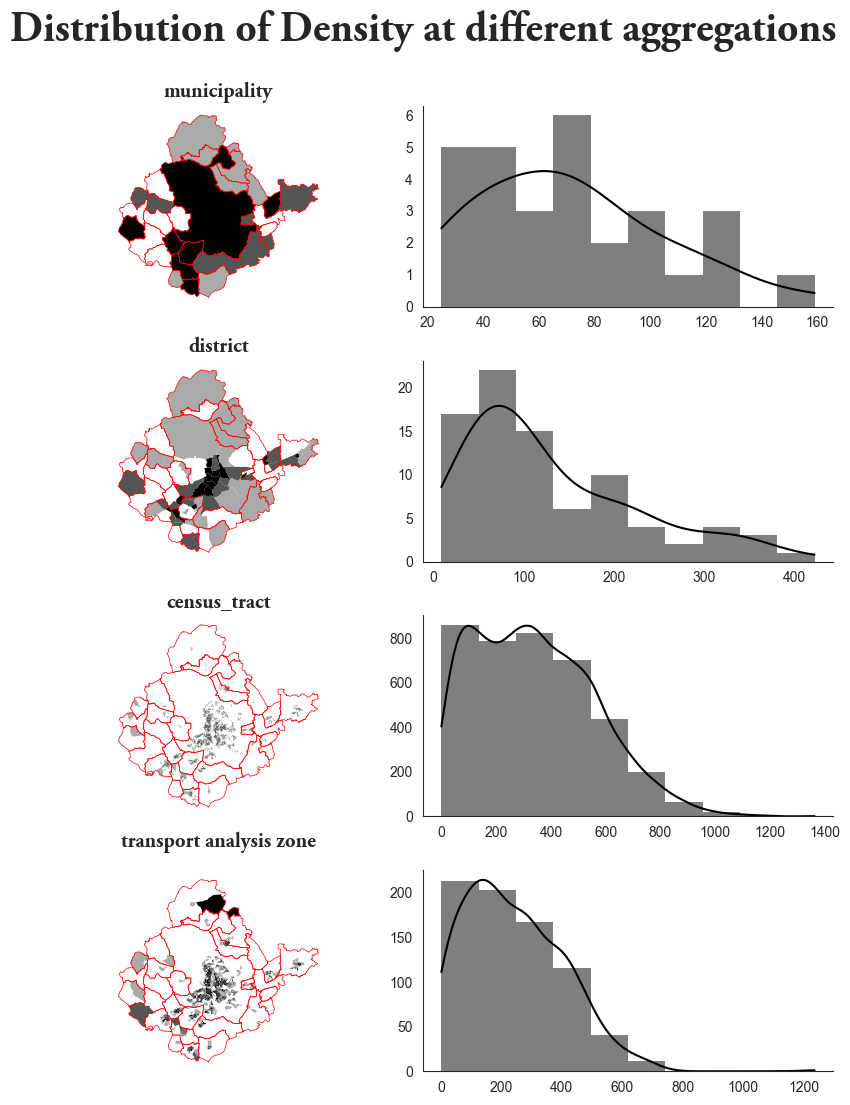

In [43]:
fig, axs = plt.subplots(4,2,figsize = (8.5, 11))
fig.suptitle('Distribution of Density at different aggregations',**csfont, fontweight="bold",y=1) # Title

for i,a in enumerate(['municipality','district','census_tract']):
    ax = axs[i][0]
    merged[merged['boundary_type']==a].plot(column='NetDensityL',categorical=True,cmap='binary',ax=ax, linewidth=0)
    muni_ref.plot(linewidth=0.5, ax = ax,color='red')
    ax.set_title(a, **hfont, fontweight="bold") # Y label
    ax.yaxis.set_label_text("")
    ax.set_xlabel('') 
    ax.axis('off')
    #a.tick_params(axis='y', **hfont)

ax = axs[3][0]
merged_tz.plot(column='NetDensityL',categorical=True,cmap='binary',ax=ax, linewidth=0)

ax.set_title('transport analysis zone', **hfont, fontweight="bold") # Y label
ax.yaxis.set_label_text("")
ax.set_xlabel('') 
ax.axis('off')

for i,a in enumerate(['municipality','district','census_tract']):
    ax = axs[i][1]
    #sn.kdeplot(data=merged[merged['boundary_type']==a], x='NetDensity', fill=True, common_norm=False,weights= 'population', ax=ax, color='k',linewidth=0)
    sn.histplot(data=merged[merged['boundary_type']==a],x='NetDensity',ax=ax, edgecolor = "none",bins=10,color='k',kde=True)#,weights= 'population',kde=True,fill=True)
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_text("") # Remove y-axis label
    #ax.set_xlim(0,1000)
    #ax.axis('off')

sn.histplot(data=merged_tz,x='NetDensity',ax=axs[3][1], edgecolor = "none",bins=10,color='k',kde=True)#,weights= 'population',kde=True,fill=True)

axs[3][1].set_xlabel('') 
#axs[3][1].set_xlim(0,1000)
muni_ref.plot(linewidth=0.5, ax = axs[3][0],color='red')
axs[3][1].spines['top'].set_visible(False)
axs[3][1].spines['right'].set_visible(False)
axs[3][1].yaxis.set_label_text("") # Remove y-axis label

#plt.title('title',**csfont)

#plt.xticks([])
#plt.yticks([])
plt.grid(False)

plt.tight_layout()
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\agregate_new.jpg")
plt.show()

Original vs Log-transformed and Standardized values for municipality:
28134    66
28115    33
28065    73
28127    44
28130    42
Name: NetDensity, dtype: int64
28134    0.080458
28115   -1.299863
28065    0.282668
28127   -0.729483
28130   -0.821994
Name: NetDensity, dtype: float64
Original vs Log-transformed and Standardized values for district:
2809201     91
2807917    100
2807902    270
2807915    222
2809202    100
Name: NetDensity, dtype: int64
2809201   -0.118926
2807917    0.001800
2807902    1.278496
2807915    1.026329
2809202    0.001800
Name: NetDensity, dtype: float64
Original vs Log-transformed and Standardized values for census_tract:
2800601041     88
2807910103    531
2807909077    270
2807915038    522
2802201001    460
Name: NetDensity, dtype: int64
2800601041   -1.022498
2807910103    0.772590
2807909077    0.095394
2807915038    0.755461
2802201001    0.628777
Name: NetDensity, dtype: float64
Original vs Log-transformed and Standardized values for transport analys

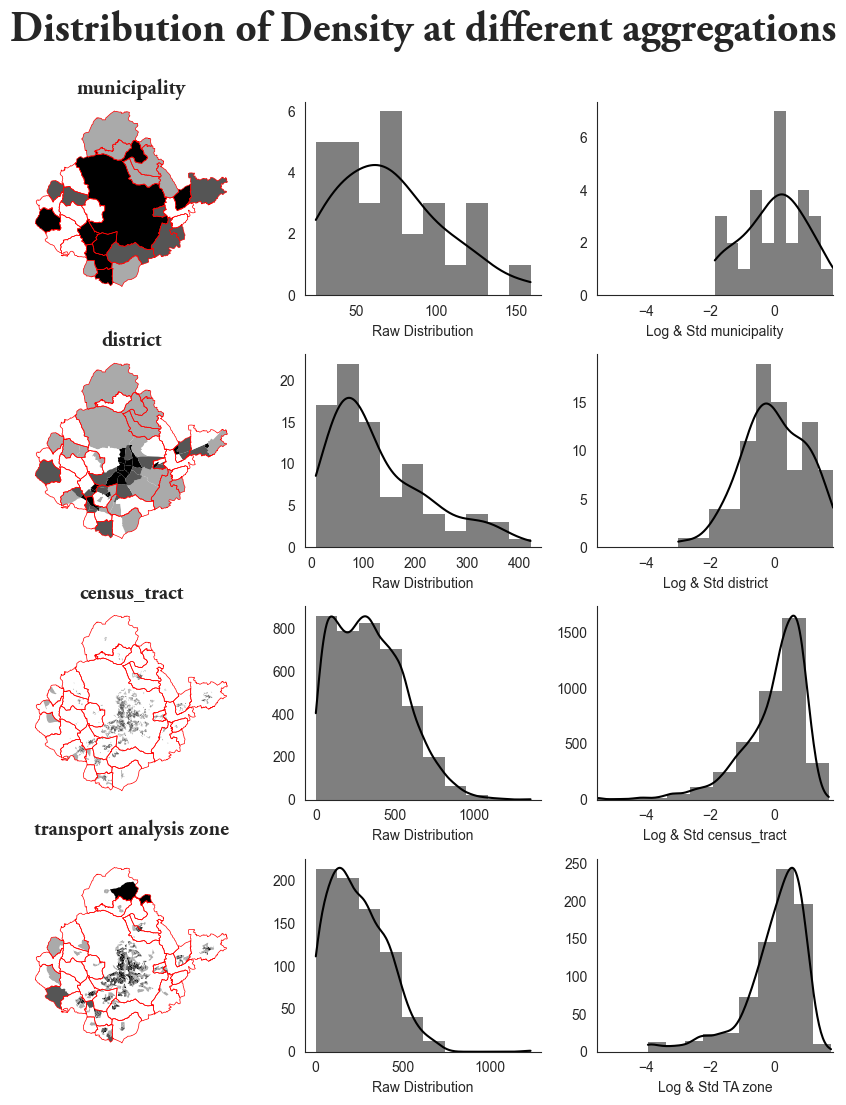

In [44]:
import numpy as np

# Log-transform and standardize function
def log_transform_standardize(series):
    series_log = np.log1p(series)  # log1p to avoid log(0) issues
    mean_val = series_log.mean()
    std_val = series_log.std()
    
    if std_val != 0:
        standardized = (series_log - mean_val) / std_val
    else:
        standardized = series_log  # If no variability, return the series as is
    
    return standardized.replace([np.inf, -np.inf], np.nan).fillna(0)

# Compute the overall x-axis range across all groups
all_log_std_data = []
for a in ['municipality', 'district', 'census_tract']:
    log_std_density = log_transform_standardize(merged[merged['boundary_type'] == a]['NetDensity'])
    all_log_std_data.append(log_std_density)

log_std_tz_density = log_transform_standardize(merged_tz['NetDensity'])
all_log_std_data.append(log_std_tz_density)

# Find the min and max across all standardized data to use for x-axis limits
min_val = min([data.min() for data in all_log_std_data])
max_val = max([data.max() for data in all_log_std_data])

fig, axs = plt.subplots(4, 3, figsize=(8.5, 11))  # Adjust figure size for three columns
fig.suptitle('Distribution of Density at different aggregations', **csfont, fontweight="bold", y=1)

for i, a in enumerate(['municipality', 'district', 'census_tract']):
    # First column: maps
    ax = axs[i][0]
    merged[merged['boundary_type'] == a].plot(column='NetDensityL', categorical=True, cmap='binary', ax=ax, linewidth=0)
    muni_ref.plot(linewidth=0.5, ax=ax, color='red')
    ax.set_title(a, **hfont, fontweight="bold")
    ax.yaxis.set_label_text("")
    ax.set_xlabel('Quartiles Map')
    ax.axis('off')

    # Second column: raw histograms
    ax = axs[i][1]
    sn.histplot(data=merged[merged['boundary_type'] == a], x='NetDensity', ax=ax, edgecolor="none", bins=10, color='k', kde=True)
    ax.set_xlabel('Raw Distribution')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_text("")

    # Third column: log-transformed and standardized histograms with shared x-axis
    log_std_density = log_transform_standardize(merged[merged['boundary_type'] == a]['NetDensity'])
    print(f"Original vs Log-transformed and Standardized values for {a}:\n{merged[merged['boundary_type'] == a]['NetDensity'].head()}\n{log_std_density.head()}")
    
    ax = axs[i][2]
    sn.histplot(data=log_std_density, ax=ax, edgecolor="none", bins=10, color='k', kde=True)
    ax.set_xlabel(f'Log & Std {a}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_text("")
    ax.set_xlim(min_val, max_val)  # Set x-axis limits for consistency

# Last row: transport analysis zone
ax = axs[3][0]
merged_tz.plot(column='NetDensityL', categorical=True, cmap='binary', ax=ax, linewidth=0)
ax.set_title('transport analysis zone', **hfont, fontweight="bold")
ax.yaxis.set_label_text("")
ax.set_xlabel('Quartiles Map')
ax.axis('off')

# Raw histogram for transport analysis zone
sn.histplot(data=merged_tz, x='NetDensity', ax=axs[3][1], edgecolor="none", bins=10, color='k', kde=True)
axs[3][1].set_xlabel('Raw Distribution')
axs[3][1].spines['top'].set_visible(False)
axs[3][1].spines['right'].set_visible(False)
axs[3][1].yaxis.set_label_text("")

# Log-transformed and standardized histogram for transport analysis zone with shared x-axis
log_std_tz_density = log_transform_standardize(merged_tz['NetDensity'])
print(f"Original vs Log-transformed and Standardized values for transport analysis zone:\n{merged_tz['NetDensity'].head()}\n{log_std_tz_density.head()}")

sn.histplot(data=log_std_tz_density, ax=axs[3][2], edgecolor="none", bins=10, color='k', kde=True)
axs[3][2].set_xlabel('Log & Std TA zone')
axs[3][2].spines['top'].set_visible(False)
axs[3][2].spines['right'].set_visible(False)
axs[3][2].yaxis.set_label_text("")
axs[3][2].set_xlim(min_val, max_val)  # Set x-axis limits for consistency

# Final adjustments
muni_ref.plot(linewidth=0.5, ax=axs[3][0], color='red')
plt.tight_layout()
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\agregate_new_with_log_transformed_shared_x.jpg")
plt.show()


Trip Frequency

In [45]:
merged_tz = pd.merge( env[env['boundary_type']=='tz'].set_index('boundary_id'),
gdf[['ZT1259','geometry']].set_index('ZT1259'), left_index=True, right_index=True)

merged_tz = gpd.GeoDataFrame(merged_tz,geometry='geometry')
merged_tz['NetDensity'] = merged_tz['population'] / (merged_tz['parcel_area'] / 1000000)
merged_tz['NetDensity'] = merged_tz['NetDensity'].fillna(0).astype(int)


In [46]:
df[(df['TripPurpose'].isin(['Shopping', 'Leisure', 'Care', 'Sport / Stroll'])) & (df['TransportMode']=='Motor - Personal')].groupby(['VDESZT1259','TripPurpose'])['ELE_G_POND'].sum().reset_index().set_index('VDESZT1259')

TripPurpose  ELE_G_POND
VDESZT1259                            
002-001               Care   52.288682
002-001           Shopping   69.987621
002-002            Leisure   60.491468
005-001           Shopping   60.911187
005-002               Care  141.742906
...                    ...         ...
903-008A          Shopping  197.237880
903-008A    Sport / Stroll  660.088505
903-008B              Care  116.654844
903-010               Care  692.242503
903-010     Sport / Stroll  263.817447

[2480 rows x 2 columns]

In [47]:
merged_tz

boundary_type  housing  population  care_area  leisure_area  \
079-20-558             tz      504        1483        316           525   
079-05-095             tz     2674        7768       3860             0   
079-11-276             tz     2742        6364          0          3374   
058-024                tz     4158       11979        646             0   
092-011                tz     3068        8337        902          7825   
...                   ...      ...         ...        ...           ...   
079-05-092A            tz     2307        6198      13415             0   
005-023                tz     4466       11882       4389             0   
079-05-092B            tz        0           0          0             0   
079-15-420             tz     3327        8851          0             0   
079-16-443             tz     2944        7945        530             0   

             retail_area  sport_area  parcel_area  parcel_built_area  \
079-20-558           859          86      3489149            3341024   
079-05-095         11420        1749     20415995           62836900   
079-11-276         11389       10376      9876646           47491478   
058-024            33534          39      9567519           36228094   
092-011            25333         357      5343796           29572314   
...                  ...         ...          ...                ...   
079-05-092A        24603        1892     11863458           67702599   
005-023            30233        1429      9282517           40441067   
079-05-092B            0           0      1223284            3194960   
079-15-420         28554         355      3116649           12333463   
079-16-443         10667        8879     16659498           45836496   

             parcel_built_ag  \
079-20-558           2838882   
079-05-095          36784114   
079-11-276          36871252   
058-024             28835775   
092-011             25820857   
...                      ...   
079-05-092A         47904384   
005-023             33255789   
079-05-092B          2638628   
079-15-420           9671187   
079-16-443          31112377   

                                                      geometry  NetDensity  
079-20-558   POLYGON ((452416.106 4476865.531, 452404.342 4...         425  
079-05-095   POLYGON ((443654.012 4478905.868, 443636.55 44...         380  
079-11-276   POLYGON ((439275.042 4471746.819, 439274.341 4...         644  
058-024      POLYGON ((432668.531 4459528.235, 432667.203 4...        1252  
092-011      POLYGON ((426757.015 4464251.86, 426757.449 44...        1560  
...                                                        ...         ...  
079-05-092A  POLYGON ((442002.774 4478389.665, 442007.134 4...         522  
005-023      POLYGON ((470145.17 4482153.729, 470134.891 44...        1280  
079-05-092B  POLYGON ((441688.805 4478387.209, 441683.968 4...           0  
079-15-420   POLYGON ((445993.289 4475897.225, 445988.927 4...        2839  
079-16-443   POLYGON ((443739.754 4480966.45, 443738.869 44...         476  

[1014 rows x 12 columns]

In [48]:
merged_frequency = pd.merge(df[(df['TripPurpose'].isin(['Shopping', 'Leisure', 'Care', 'Sport / Stroll'])) & (df['TransportMode']=='Motor - Personal')].groupby(['VDESZT1259','TripPurpose'])['ELE_G_POND'].sum().reset_index().set_index('VDESZT1259'), merged_tz, left_index=True,right_index=True)

In [49]:
(merged_frequency[merged_frequency['TripPurpose']=='Shopping']['ELE_G_POND'] / merged_frequency[merged_frequency['TripPurpose']=='Shopping']['retail_area']).replace([np.inf, -np.inf], np.nan).dropna().describe()

count    512.000000
mean       0.063270
std        0.644186
min        0.000278
25%        0.004610
50%        0.010112
75%        0.026342
max       14.377691
dtype: float64

In [50]:
(merged_frequency[merged_frequency['TripPurpose']=='Leisure']['ELE_G_POND'] / merged_frequency[merged_frequency['TripPurpose']=='Leisure']['leisure_area']).replace([np.inf, -np.inf], np.nan).dropna().describe()

count    138.000000
mean       0.175745
std        0.341707
min        0.002187
25%        0.022660
50%        0.062969
75%        0.166601
max        3.012049
dtype: float64

In [51]:
(merged_frequency[merged_frequency['TripPurpose']=='Care']['ELE_G_POND'] / merged_frequency[merged_frequency['TripPurpose']=='Care']['care_area']).replace([np.inf, -np.inf], np.nan).dropna().describe()

count    550.000000
mean       0.474914
std        1.093661
min        0.000747
25%        0.041840
50%        0.104001
75%        0.322183
max        8.884414
dtype: float64

In [52]:
(merged_frequency[merged_frequency['TripPurpose']=='Sport / Stroll']['ELE_G_POND'] / merged_frequency[merged_frequency['TripPurpose']=='Sport / Stroll']['sport_area']).replace([np.inf, -np.inf], np.nan).dropna().describe()

count    426.000000
mean       0.126014
std        0.714755
min        0.000441
25%        0.009811
50%        0.022076
75%        0.053246
max       13.821651
dtype: float64

In [53]:
merged.boundary_type.unique()

array(['census_tract', 'district', 'municipality', 'province'],
      dtype=object)

In [54]:
continuous

{'EDAD_FIN': ('Age', (0, 0)),
 'N_MIEMBROS_POR_HOGAR': ('HouseholdSize', (0, 1)),
 'N_VIAJES_POR_HOGAR': ('TripsHousehold', (1, 0)),
 'N_ETAPAS_POR_VIAJE': ('TripStages', (1, 1)),
 'VORIHORAINI': ('StartTime', (2, 0)),
 'VDESHORAFIN': ('EndTime', (2, 1)),
 'DURACION_VIAJE': ('TripDuration', (3, 0)),
 'VELOCIDAD_VIAJE': ('TripSpeed', (3, 1))}

C:\Users\katul\AppData\Local\Temp\ipykernel_9388\563340380.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\563340380.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\563340380.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\563340380.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(d.index, rotation=0,**hfont)
C:\Users\katul\AppData\Local

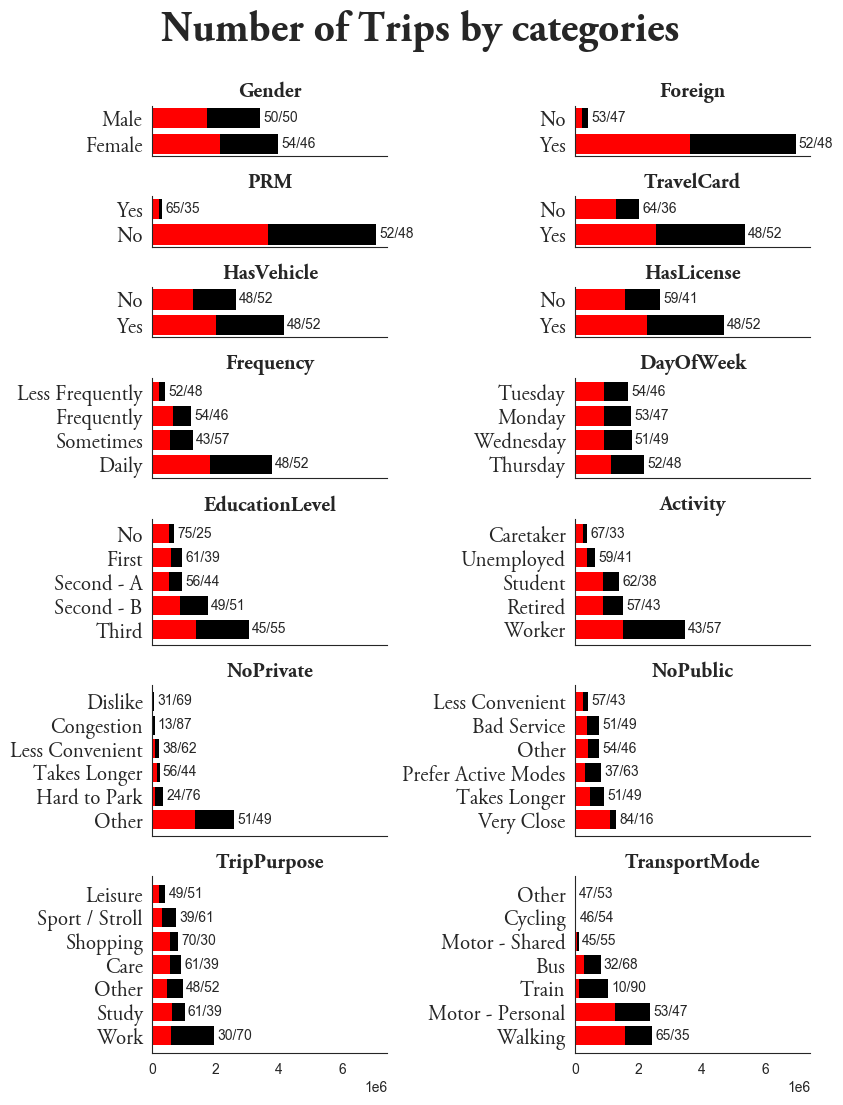

In [55]:

fig, axs = plt.subplots(7, 2, figsize=(8.5, 11), gridspec_kw={'height_ratios': [2, 2, 2, 4,5,6,7]},sharex=True) 

#fig.add_gridspec(nrows=7, ncols=2, height_ratios=[2, 2, 2, 4,5,6,7])

fig.suptitle('Number of Trips by categories', fontweight="bold", y=1, **csfont)  # Title

colors = {"15-minutes trip": "red", "longer trip": "black"}

for c, i in categorical.items():
    d = df.copy(deep=True)

    d['15MC'] = d['TripDuration'].apply(lambda x: "15-minutes trip" if x <= 15 else "longer trip")

    d = d.groupby([i[0], '15MC'])['ELE_G_POND'].sum().unstack().fillna(0)
    d = d.loc[d.index != "0"]
    
    # Sort the dataframe by the sum of ELE_G_POND values
    d['Total'] = d.sum(axis=1)
    d = d.sort_values(by='Total', ascending=False).drop(columns='Total')
    
    a = axs[i[2][0]][i[2][1]]
    
    # Plot each category manually to control the colors
    bottom = [0] * len(d)
    for category in d.columns:
        a.barh(d.index, d[category], color=colors[category], edgecolor='none', label=category, left=bottom)
        bottom = bottom + d[category].values

    for j, (index, row) in enumerate(d.iterrows()):
        p15 = row['15-minutes trip']
        plt_ = row['longer trip']
        total = p15 + plt_
        p15_pct = int(round((p15 / total) * 100))
        plt_pct = int(round((plt_ / total) * 100))
        label = f"{p15_pct}/{plt_pct}"
        x_pos = row['15-minutes trip'] + row['longer trip']
        a.text(x_pos+100000, j, label,va='center',ha='left')

    a.set_title(i[0], fontweight="bold",**hfont)  # Title
    #a.set_xlabel('ELE_G_POND')
    a.set_ylabel('')
    a.set_yticklabels(d.index, rotation=0,**hfont)
    a.set_xlabel('') 
    #a.axis('off')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\dissagregate_new.jpg")
plt.show()

In [56]:
11 / 28
0.39 * 7
2.73 * 3

8.19

In [57]:
continuous = {
    'EDAD_FIN':('Age',(0,0)),
    'N_MIEMBROS_POR_HOGAR':('HouseholdSize',(0,1)),
    'N_VIAJES_POR_HOGAR':('TripsHousehold',(1,0)),
    'VELOCIDAD_VIAJE':('TripSpeed',(1,1)),
    'VORIHORAINI':('StartTime',(2,0)),
    'VDESHORAFIN':('EndTime',(2,1))
    }

In [58]:
continuous_bins = {
    'Age': np.arange(0, 100, 10),
    'HouseholdSize': np.arange(0, 6, 1),
    'TripsHousehold': np.arange(0, 20, 5),
    'TripSpeed': np.arange(0, 70, 5),
    'StartTime': np.arange(0, 24, 3),
    'EndTime': np.arange(0, 24, 3),
}

C:\Users\katul\AppData\Local\Temp\ipykernel_9388\2217125699.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_counts = df.groupby(['bin_label', '15MC']).size().unstack().fillna(0)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\2217125699.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_counts = df.groupby(['bin_label', '15MC']).size().unstack().fillna(0)
C:\Users\katul\AppData\Local\Temp\ipykernel_9388\2217125699.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

<Figure size 640x480 with 0 Axes>

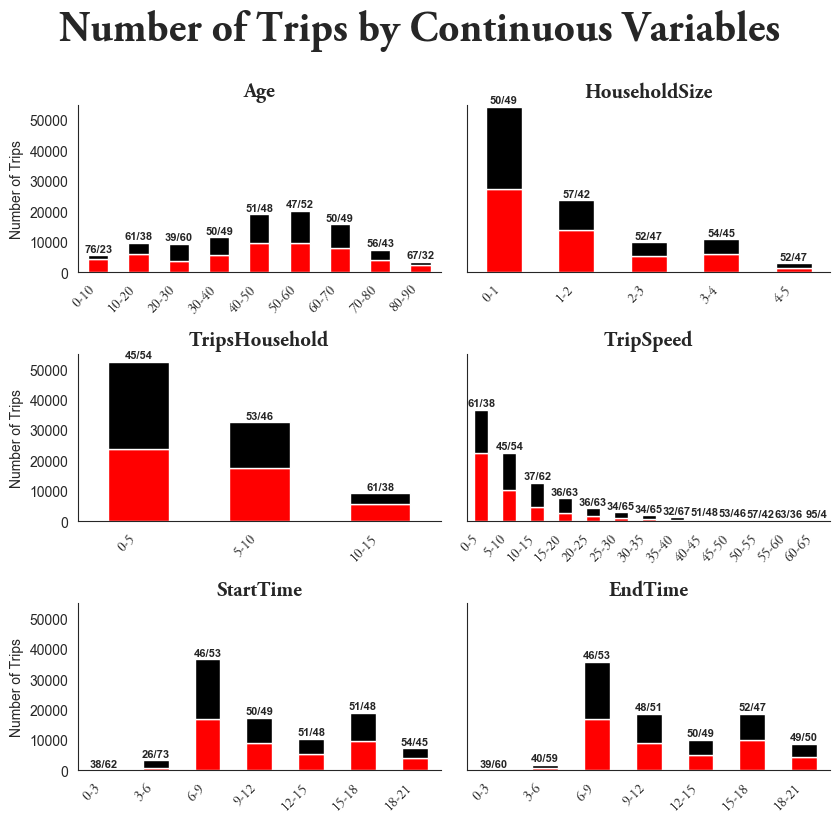

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is already defined and loaded with your data
my_pal = {"15-minutes trip": "r", "longer trip": "k"}

# Create the new category for trips
df['15MC'] = df['TripDuration'].apply(lambda x: "15-minutes trip" if x <= 15 else "longer trip")

# Define the bin edges for each continuous variable
continuous_bins = {
    'Age': np.arange(0, 100, 10),
    'HouseholdSize': np.arange(0, 6, 1),
    'TripsHousehold': np.arange(0, 20, 5),
    'TripSpeed': np.arange(0, 70, 5),
    'StartTime': np.arange(0, 24, 3),
    'EndTime': np.arange(0, 24, 3),
}

# Clear the figure if it was used before
plt.clf()

# Set up the figure and axes for subplots, sharing y-axis for each row
fig, axs = plt.subplots(3, 2, figsize=(8.5, 8.19), sharey='row')
fig.suptitle('Number of Trips by Continuous Variables', fontweight="bold", y=1, **csfont) # Title

# Iterate over the continuous variables and create stacked bar plots
for c, i in continuous.items():
    a = axs[i[1][0]][i[1][1]]
    
    # Get the binning for the current variable
    bins = continuous_bins.get(i[0], 10)  # Default to 10 bins if not specified
    
    # Create the bucketed counts for each category ("15-minutes trip" and "longer trip")
    df['binned'] = pd.cut(df[i[0]], bins=bins)
    
    # Generate readable bin labels (e.g., "0-10", "10-20", etc.)
    df['bin_label'] = df['binned'].apply(lambda x: f"{int(x.left)}-{int(x.right)}" if pd.notna(x) else "N/A")
    
    # Group the data by bin labels and trip category, count occurrences
    trip_counts = df.groupby(['bin_label', '15MC']).size().unstack().fillna(0)
    
    # Plot stacked bar chart with readable labels
    bars = trip_counts.plot(kind='bar', stacked=True, color=[my_pal['15-minutes trip'], my_pal['longer trip']], ax=a, legend=False)
    
    # Customize the plot appearance
    a.set_title(i[0], fontweight="bold", **hfont) # Set title for each subplot
    a.set_ylabel('Number of Trips') if i[1][1] == 0 else a.set_ylabel('')  # Set y-axis label only for the left column
    a.set_xlabel('')  # Remove x-axis label for each subplot
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

    # Rotate the x-axis labels for better readability
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right', fontname='Adobe Garamond Pro',)
    
    # Set the y-axis limit to a maximum of 50,000
    a.set_ylim(0, 55000)

    # Add percentage labels on top of each stacked bar
    for index, row in trip_counts.iterrows():
        red_value = row['15-minutes trip']
        black_value = row['longer trip']
        total_value = red_value + black_value
        
        if total_value > 0:
            red_pct = int((red_value / total_value) * 100)
            black_pct = int((black_value / total_value) * 100)
            
            # Get the x position (center of the bar) and y position (top of the stacked bar)
            bar_index = list(trip_counts.index).index(index)
            x = bar_index
            y = red_value + black_value
            
            # Add the label at the top of the stack
            a.text(x, y + 500, f"{red_pct}/{black_pct}", ha="center", va="bottom", fontweight="bold", fontsize=8)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\dissagregate_continuous.jpg")

plt.show()


In [60]:
df['CODMUNI'] = df['CODMUNI'].astype(str)
df['TransportMode'] = df['TransportMode'].astype(str)
df['ELE_G_POND'] = pd.to_numeric(df['ELE_G_POND'], errors='coerce')


In [61]:
8.19/3
(8.19/3)*4

10.92

In [62]:
transport_mode = pd.merge(
df[~df['TransportMode'].isna()].groupby(['CODMUNI','TransportMode'])['ELE_G_POND'].sum().rename('typetrips').reset_index().set_index('CODMUNI'),
df[~df['TransportMode'].isna()].groupby('CODMUNI')['ELE_G_POND'].sum().rename('totaltrips'),
left_index = True,
right_index = True
)
transport_mode['ptrps'] = round(transport_mode.typetrips * 100 / transport_mode.totaltrips,0).astype(int)


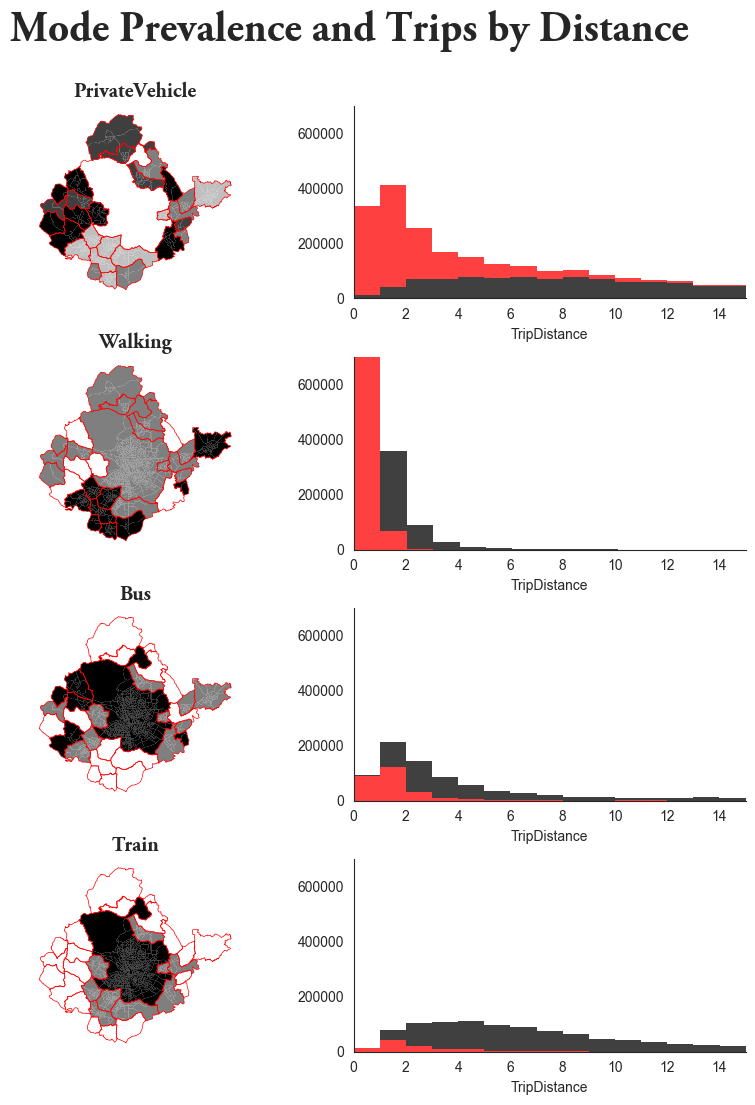

In [63]:
my_pal = {"15-minutes trip": "r", "longer trip": "k"}

fig, ax = plt.subplots(4,2,figsize = (8.5,11))
fig.suptitle('Mode Prevalence and Trips by Distance',**csfont, fontweight="bold",y=1) # Title

gpd.GeoDataFrame(
    pd.merge(transport_mode[transport_mode['TransportMode']=='Motor - Personal']['ptrps'].rename('motor').reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry').plot(
        column = 'motor', scheme='natural_breaks',cmap='binary',linewidth=0, ax = ax[0][0])
muni_ref.plot(linewidth=0.5, ax = ax[0][0],color='red')
ax[0][0].set_title("PrivateVehicle", **hfont, fontweight="bold") # Y label
ax[0][0].yaxis.set_label_text("")
ax[0][0].set_xlabel('') 
ax[0][0].axis('off')

d = df[df['TransportMode']=='Motor - Personal']
d.loc[d['TripDuration']<=15,'15MC'] = "15-minutes trip"
d.loc[d['TripDuration']>15,'15MC'] = "longer trip"
sn.histplot(
    d,x='TripDistance',
    ax=ax[0][1],
    weights = 'ELE_G_POND',
    binwidth = 1,
    color='#000000',fill=True,hue='15MC',multiple='stack',palette=my_pal,linewidth=0,legend=False )
ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].yaxis.set_label_text("")
ax[0][1].set_ylim(0,700000)
ax[0][1].set_xlim(0,15)

gpd.GeoDataFrame(
    pd.merge(transport_mode[transport_mode['TransportMode']=='Walking']['ptrps'].rename('walking').reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry').plot(
        column = 'walking', scheme='natural_breaks',k=3,cmap='binary',linewidth=0, ax = ax[1][0])
muni_ref.plot(linewidth=0.5, ax = ax[1][0],color='red')
ax[1][0].set_title("Walking", **hfont, fontweight="bold") # Y label
ax[1][0].yaxis.set_label_text("")
ax[1][0].set_xlabel('') 
ax[1][0].axis('off')


d = df[df['TransportMode']=='Walking']
d.loc[d['TripDuration']<=15,'15MC'] = "15-minutes trip"
d.loc[d['TripDuration']>15,'15MC'] = "longer trip"
sn.histplot(
    d,x='TripDistance',
    ax=ax[1][1],
    weights = 'ELE_G_POND',
    binwidth = 1,
    color='#000000',fill=True,hue='15MC',multiple='stack',palette=my_pal,linewidth=0,legend=False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].set_ylim(0,700000)
ax[1][1].set_xlim(0,15)
ax[1][1].yaxis.set_label_text("")

gpd.GeoDataFrame(
    pd.merge(transport_mode[transport_mode['TransportMode']=='Bus']['ptrps'].rename('bus').reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry').plot(
        column = 'bus', scheme='natural_breaks',k=3,cmap='binary',linewidth=0, ax = ax[2][0])
muni_ref.plot(linewidth=0.5, ax = ax[2][0],color='red')
ax[2][0].set_title("Bus", **hfont, fontweight="bold") # Y label
ax[2][0].yaxis.set_label_text("")
ax[2][0].set_xlabel('') 
ax[2][0].axis('off')


d = df[df['TransportMode']=='Bus']
d.loc[d['TripDuration']<=15,'15MC'] = "15-minutes trip"
d.loc[d['TripDuration']>15,'15MC'] = "longer trip"
sn.histplot(
    d,x='TripDistance',ax=ax[2][1],
    weights = 'ELE_G_POND',
    binwidth = 1,
    color='#000000',fill=True,hue='15MC',multiple='stack',palette=my_pal,linewidth=0,legend=False )
ax[2][1].spines['top'].set_visible(False)
ax[2][1].spines['right'].set_visible(False)
ax[2][1].set_ylim(0,700000)
ax[2][1].set_xlim(0,15)
ax[2][1].yaxis.set_label_text("")

gpd.GeoDataFrame(
    pd.merge(transport_mode[transport_mode['TransportMode']=='Train']['ptrps'].rename('train').reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry').plot(
        column = 'train', scheme='natural_breaks',k=3,cmap='binary',linewidth=0, ax = ax[3][0])
muni_ref.plot(linewidth=0.5, ax = ax[3][0],color='red')
ax[3][0].set_title("Train", **hfont, fontweight="bold") # Y label
ax[3][0].yaxis.set_label_text("")
ax[3][0].set_xlabel('') 
ax[3][0].axis('off')


d = df[df['TransportMode']=='Train']
d.loc[d['TripDuration']<=15,'15MC'] = "15-minutes trip"
d.loc[d['TripDuration']>15,'15MC'] = "longer trip"
sn.histplot(
    d,x='TripDistance',
    ax=ax[3][1],
    weights = 'ELE_G_POND',
    binwidth = 1,
    color='#000000',
    fill=True,hue='15MC',multiple='stack',palette=my_pal,linewidth=0 ,legend=False)
ax[3][1].spines['top'].set_visible(False)
ax[3][1].spines['right'].set_visible(False)
ax[3][1].set_ylim(0,700000)
ax[3][1].set_xlim(0,15)
ax[3][1].yaxis.set_label_text("")

#plt.yticks([])
plt.grid(False)

plt.tight_layout()
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\choicemodel_color.jpg")

plt.show()

In [64]:
merged_tz['NetDensityL'] = quantiles(merged_tz['NetDensity'])
merged_tz

boundary_type  housing  population  care_area  leisure_area  \
079-20-558             tz      504        1483        316           525   
079-05-095             tz     2674        7768       3860             0   
079-11-276             tz     2742        6364          0          3374   
058-024                tz     4158       11979        646             0   
092-011                tz     3068        8337        902          7825   
...                   ...      ...         ...        ...           ...   
079-05-092A            tz     2307        6198      13415             0   
005-023                tz     4466       11882       4389             0   
079-05-092B            tz        0           0          0             0   
079-15-420             tz     3327        8851          0             0   
079-16-443             tz     2944        7945        530             0   

             retail_area  sport_area  parcel_area  parcel_built_area  \
079-20-558           859          86      3489149            3341024   
079-05-095         11420        1749     20415995           62836900   
079-11-276         11389       10376      9876646           47491478   
058-024            33534          39      9567519           36228094   
092-011            25333         357      5343796           29572314   
...                  ...         ...          ...                ...   
079-05-092A        24603        1892     11863458           67702599   
005-023            30233        1429      9282517           40441067   
079-05-092B            0           0      1223284            3194960   
079-15-420         28554         355      3116649           12333463   
079-16-443         10667        8879     16659498           45836496   

             parcel_built_ag  \
079-20-558           2838882   
079-05-095          36784114   
079-11-276          36871252   
058-024             28835775   
092-011             25820857   
...                      ...   
079-05-092A         47904384   
005-023             33255789   
079-05-092B          2638628   
079-15-420           9671187   
079-16-443          31112377   

                                                      geometry  NetDensity  \
079-20-558   POLYGON ((452416.106 4476865.531, 452404.342 4...         425   
079-05-095   POLYGON ((443654.012 4478905.868, 443636.55 44...         380   
079-11-276   POLYGON ((439275.042 4471746.819, 439274.341 4...         644   
058-024      POLYGON ((432668.531 4459528.235, 432667.203 4...        1252   
092-011      POLYGON ((426757.015 4464251.86, 426757.449 44...        1560   
...                                                        ...         ...   
079-05-092A  POLYGON ((442002.774 4478389.665, 442007.134 4...         522   
005-023      POLYGON ((470145.17 4482153.729, 470134.891 44...        1280   
079-05-092B  POLYGON ((441688.805 4478387.209, 441683.968 4...           0   
079-15-420   POLYGON ((445993.289 4475897.225, 445988.927 4...        2839   
079-16-443   POLYGON ((443739.754 4480966.45, 443738.869 44...         476   

            NetDensityL  
079-20-558         0.75  
079-05-095         0.75  
079-11-276         0.75  
058-024            1.00  
092-011            1.00  
...                 ...  
079-05-092A        0.75  
005-023            1.00  
079-05-092B        0.25  
079-15-420         1.00  
079-16-443         0.75  

[1014 rows x 13 columns]

In [65]:
merged_tz = merged_tz[merged_tz['NetDensity']>0]

In [66]:
"""
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sn
import pandas as pd
import statsmodels.api as sm

# Step 1: Calculate %CarTrips
# Group by 'VORIZT1259' and 'TransportMode' and calculate the percentage of 'Motor - Personal'
df_grouped = df.groupby(['VORIZT1259', 'TransportMode'])['ELE_G_POND'].sum().reset_index()
df_total = df_grouped.groupby('VORIZT1259')['ELE_G_POND'].sum().reset_index(name='total_trips')

# Merge to calculate % of 'Motor - Personal'
df_grouped = df_grouped.merge(df_total, on='VORIZT1259')
df_grouped['%CarTrips'] = df_grouped.apply(
    lambda row: (row['ELE_G_POND'] / row['total_trips']) * 100 if row['TransportMode'] == 'Motor - Personal' else 0,
    axis=1
)

# Extract %CarTrips for 'Motor - Personal' mode
df_car_trips = df_grouped[df_grouped['TransportMode'] == 'Motor - Personal'][['VORIZT1259', '%CarTrips']]

# Step 2: Create 'MUNI' by splitting 'VORIZT1259' and adding "28"
df_car_trips['MUNI'] = '28' + df_car_trips['VORIZT1259'].str.split('-').str[0]

# Step 3: Merge %CarTrips with the municipality and transport zone dataframes
# Merge with 'merged_tz' for transport zone aggregation
merged_tz = merged_tz.merge(df_car_trips, left_index=True, right_on='VORIZT1259', how='left')

# Merge with 'merged' for municipality aggregation
merged_muni = merged[merged['boundary_type'] == 'municipality']
merged_muni = merged_muni.merge(df_car_trips, left_index=True, right_on='MUNI', how='left')

# Initialize Figure and Axes
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
fig.suptitle('Density (Quartiles) and % Car Trips by Municipalities and Transport Zones', fontsize=16, fontweight="bold")

# Row 1: Map of Density Quartiles
# Municipal Aggregation
merged_muni.plot(
    column='NetDensityL', cmap='Blues', ax=axs[0, 0], legend=True, categorical=True,linewidth=0.0)
muni_ref.plot(ax=axs[0, 0], color='red', linewidth=0.5)
axs[0, 0].set_title('Density Quartiles (Municipality)', fontweight="bold")
axs[0, 0].axis('off')

# Transport Zone Aggregation
merged_tz.plot(column='NetDensityL', cmap='Blues', ax=axs[0, 1], legend=True, categorical=True,linewidth=0.0)
muni_ref.plot(ax=axs[0, 1], color='red', linewidth=0.5)
axs[0, 1].set_title('Density Quartiles (Transport Zone)', fontweight="bold")
axs[0, 1].axis('off')

# Row 2: Map of Percentage of Car Trips
# Municipal Aggregation
merged_muni.plot(
    column='%CarTrips', cmap='OrRd', ax=axs[1, 0], legend=True,linewidth=0.0)
muni_ref.plot(ax=axs[1, 0], color='red', linewidth=0.5)
axs[1, 0].set_title('% Car Trips (Municipality)', fontweight="bold")
axs[1, 0].axis('off')

# Transport Zone Aggregation
merged_tz.plot(column='%CarTrips', cmap='OrRd', ax=axs[1, 1], legend=True,linewidth=0.0)
muni_ref.plot(ax=axs[1, 1], color='red', linewidth=0.5)
axs[1, 1].set_title('% Car Trips (Transport Zone)', fontweight="bold")
axs[1, 1].axis('off')

# Row 3: Table of Descriptive Statistics
# Municipal Aggregation
desc_muni = merged_muni[['NetDensity', '%CarTrips']].describe().loc[['max', 'mean', 'min', 'std']]
axs[2, 0].axis('off')
axs[2, 0].table(cellText=desc_muni.values, rowLabels=desc_muni.index, colLabels=desc_muni.columns, loc='center')
axs[2, 0].set_title('Descriptive Stats (Municipality)', fontweight="bold")

# Transport Zone Aggregation
desc_tz = merged_tz[['NetDensity', '%CarTrips']].describe().loc[['max', 'mean', 'min', 'std']]
axs[2, 1].axis('off')
axs[2, 1].table(cellText=desc_tz.values, rowLabels=desc_tz.index, colLabels=desc_tz.columns, loc='center')
axs[2, 1].set_title('Descriptive Stats (Transport Zone)', fontweight="bold")

# Row 4: OLS Regression Plot
# Municipal Aggregation
X_muni = merged_muni['NetDensity']
y_muni = merged_muni['%CarTrips']
X_muni = sm.add_constant(X_muni)
model_muni = sm.OLS(y_muni, X_muni).fit()
merged_muni['pred_muni'] = model_muni.predict(X_muni)

sn.regplot(x='NetDensity', y='%CarTrips', data=merged_muni, 
           scatter_kws={'s':10}, line_kws={"color":"r"}, ax=axs[3, 0])
axs[3, 0].set_title('OLS Regression (Municipality)', fontweight="bold")

# Transport Zone Aggregation
X_tz = merged_tz['NetDensity']
y_tz = merged_tz['%CarTrips']
X_tz = sm.add_constant(X_tz)
model_tz = sm.OLS(y_tz, X_tz).fit()
merged_tz['pred_tz'] = model_tz.predict(X_tz)

sn.regplot(x='NetDensity', y='%CarTrips', data=merged_tz, 
           scatter_kws={'s':10}, line_kws={"color":"r"}, ax=axs[3, 1])
axs[3, 1].set_title('OLS Regression (Transport Zone)', fontweight="bold")

# Final Layout Adjustments and Display
plt.tight_layout()
plt.savefig('density_car_trips_correlation.jpg')
plt.show()
"""


'\nimport matplotlib.pyplot as plt\nimport geopandas as gpd\nimport seaborn as sn\nimport pandas as pd\nimport statsmodels.api as sm\n\n# Step 1: Calculate %CarTrips\n# Group by \'VORIZT1259\' and \'TransportMode\' and calculate the percentage of \'Motor - Personal\'\ndf_grouped = df.groupby([\'VORIZT1259\', \'TransportMode\'])[\'ELE_G_POND\'].sum().reset_index()\ndf_total = df_grouped.groupby(\'VORIZT1259\')[\'ELE_G_POND\'].sum().reset_index(name=\'total_trips\')\n\n# Merge to calculate % of \'Motor - Personal\'\ndf_grouped = df_grouped.merge(df_total, on=\'VORIZT1259\')\ndf_grouped[\'%CarTrips\'] = df_grouped.apply(\n    lambda row: (row[\'ELE_G_POND\'] / row[\'total_trips\']) * 100 if row[\'TransportMode\'] == \'Motor - Personal\' else 0,\n    axis=1\n)\n\n# Extract %CarTrips for \'Motor - Personal\' mode\ndf_car_trips = df_grouped[df_grouped[\'TransportMode\'] == \'Motor - Personal\'][[\'VORIZT1259\', \'%CarTrips\']]\n\n# Step 2: Create \'MUNI\' by splitting \'VORIZT1259\' and addi

In [67]:
merged_tz

boundary_type  housing  population  care_area  leisure_area  \
079-20-558             tz      504        1483        316           525   
079-05-095             tz     2674        7768       3860             0   
079-11-276             tz     2742        6364          0          3374   
058-024                tz     4158       11979        646             0   
092-011                tz     3068        8337        902          7825   
...                   ...      ...         ...        ...           ...   
134-015                tz     1509        3903       9322           474   
079-05-092A            tz     2307        6198      13415             0   
005-023                tz     4466       11882       4389             0   
079-15-420             tz     3327        8851          0             0   
079-16-443             tz     2944        7945        530             0   

             retail_area  sport_area  parcel_area  parcel_built_area  \
079-20-558           859          86      3489149            3341024   
079-05-095         11420        1749     20415995           62836900   
079-11-276         11389       10376      9876646           47491478   
058-024            33534          39      9567519           36228094   
092-011            25333         357      5343796           29572314   
...                  ...         ...          ...                ...   
134-015            14601       15539     63960460          210345252   
079-05-092A        24603        1892     11863458           67702599   
005-023            30233        1429      9282517           40441067   
079-15-420         28554         355      3116649           12333463   
079-16-443         10667        8879     16659498           45836496   

             parcel_built_ag  \
079-20-558           2838882   
079-05-095          36784114   
079-11-276          36871252   
058-024             28835775   
092-011             25820857   
...                      ...   
134-015            135913619   
079-05-092A         47904384   
005-023             33255789   
079-15-420           9671187   
079-16-443          31112377   

                                                      geometry  NetDensity  \
079-20-558   POLYGON ((452416.106 4476865.531, 452404.342 4...         425   
079-05-095   POLYGON ((443654.012 4478905.868, 443636.55 44...         380   
079-11-276   POLYGON ((439275.042 4471746.819, 439274.341 4...         644   
058-024      POLYGON ((432668.531 4459528.235, 432667.203 4...        1252   
092-011      POLYGON ((426757.015 4464251.86, 426757.449 44...        1560   
...                                                        ...         ...   
134-015      POLYGON ((447944.534 4488905.803, 447939.508 4...          61   
079-05-092A  POLYGON ((442002.774 4478389.665, 442007.134 4...         522   
005-023      POLYGON ((470145.17 4482153.729, 470134.891 44...        1280   
079-15-420   POLYGON ((445993.289 4475897.225, 445988.927 4...        2839   
079-16-443   POLYGON ((443739.754 4480966.45, 443738.869 44...         476   

            NetDensityL  
079-20-558         0.75  
079-05-095         0.75  
079-11-276         0.75  
058-024            1.00  
092-011            1.00  
...                 ...  
134-015            0.50  
079-05-092A        0.75  
005-023            1.00  
079-15-420         1.00  
079-16-443         0.75  

[791 rows x 13 columns]

Trip Frequencies

In [68]:
from shapely.wkt import loads
#env = pd.read_csv(r"G:\Mi unidad\walknet_datalake\extractions\test_tz10.csv")
env = pd.read_csv(r"G:\Mi unidad\walknet_datalake\extractions\fn_landuse_on_tz.csv")

#env['geometry'] = env['geometry'].apply(lambda x: loads(x))
#env = gpd.GeoDataFrame(env,geometry='geometry')

In [69]:
env

boundary_id  housing_number  care_number  school_number  leisure_number  \
0       005-001               4            2              0               7   
1       005-002            1349            0              1               2   
2       005-003           12477           11              4               5   
3       005-004               1            3            158               4   
4       005-006              28           10              1              15   
..          ...             ...          ...            ...             ...   
816     903-005            4102            4              7               9   
817     903-007            3488            1              4               7   
818    903-008A            4450            6             10              23   
819     903-009               1            0              0               2   
820     903-010            2265            1              8               3   

     shopping_number  sport_number  housing_area  housing_ch_area  \
0                 53             4          1003             1003   
1                 11             6         68785            68785   
2                157            15        798346           798346   
3                  3             3           231              231   
4                 26             1          2764             2764   
..               ...           ...           ...              ...   
816              284             3        379324           379324   
817              158            15        272861           272861   
818              255             4        445778           445778   
819                0             1           181              181   
820               70             6        270031           270031   

     housing_sfr_area  ...  parking_area  unbuilt_area  hotel_area  \
0                1003  ...          1166          5648           0   
1               68785  ...          7580         21023           0   
2              798346  ...         49260         12415           0   
3                 231  ...           740             0           0   
4                2764  ...          1035         27976           0   
..                ...  ...           ...           ...         ...   
816            379324  ...         63625             0           0   
817            272861  ...        113271             0           0   
818            445778  ...         47567             0           0   
819               181  ...           576             0           0   
820            270031  ...          5711             0           0   

     religious_area  infra_area  parcel_area  parcel_effective_built_area  \
0                 0           0      2835170                      1401071   
1                 0           0       968426                       481415   
2              1341           0       850200                      1011374   
3                 0           0      1113616                       428726   
4                 0           0       706431                       390431   
..              ...         ...          ...                          ...   
816            2383           0       322849                       520878   
817               0           0       250367                       445338   
818            2271           0       441527                       574962   
819               0           0       199394                        70475   
820               0           0       268331                       309928   

     parcel_built_area  parcel_built_ag   year_built  
0              1679988          1648872  1979.654369  
1               554218           515359  1880.362573  
2              1341603           972494  1559.264038  
3               487847           451387  1993.974026  
4               416873           404255  1981.617284  
..                 ...              ...          ...  
816             695593           545595  1987.783133  
817             5610

In [70]:
iterates = pd.read_csv(r"C:\Documents\Github\pw_sources\sources\ite_rates.csv",sep=";")
iterates = iterates[iterates['TripPurpose'].notnull()]

#iterates[iterates['Unit of Measure']==' 1,000 SF GFA'][' Trips Per Unit 1']
iterates.loc[iterates['Unit of Measure']==' 1,000 SF GFA','ITE Rates'] = round((iterates[iterates['Unit of Measure']==' 1,000 SF GFA'][' Trips Per Unit 1']) / 92.903,3)
iterates.loc[iterates['Unit of Measure']==' Acres','ITE Rates'] = round((iterates[iterates['Unit of Measure']==' Acres'][' Trips Per Unit 1']) / 92.903,3)
iterates.loc[iterates['Unit of Measure']==' Dwelling Units','ITE Rates'] = (iterates[iterates['Unit of Measure']==' Dwelling Units'][' Trips Per Unit 1'])
iterates['Cadastral'] = iterates['Cadastral'].str.strip()
iterates['Cadastral'].unique()
iterates['TripPurpose'] = iterates['TripPurpose'].str.strip()

In [71]:
env['boundary_type']= 'tz'

In [72]:
areas_edm = env.groupby('boundary_type') [['housing_area','care_area', 'school_area','leisure_area','shopping_area', 'sport_area']].sum().unstack().reset_index()
areas_edm = areas_edm.rename(columns={'level_0':'Cadastral',0:'Area/Units'}).drop(columns=['boundary_type'])
areas_edm = pd.Series(areas_edm['Area/Units'].values,index=areas_edm['Cadastral']).to_dict()

In [73]:
iterates['Area/Units'] = iterates['Cadastral'].map(areas_edm)

In [74]:
iterates['Cadastral']

14      housing_area
15      housing_area
16      housing_area
17      housing_area
18      housing_area
19      housing_area
24         care_area
34               NaN
42      leisure_area
46      leisure_area
47      leisure_area
50      leisure_area
60        sport_area
61        sport_area
62      leisure_area
63       school_area
64       school_area
65       school_area
75         care_area
79      leisure_area
80      leisure_area
81         care_area
82         care_area
83         care_area
86               NaN
87               NaN
88               NaN
89               NaN
97               NaN
102    shopping_area
107    shopping_area
115    shopping_area
118    shopping_area
120    shopping_area
131    shopping_area
132    shopping_area
144     leisure_area
146     leisure_area
147     leisure_area
148     leisure_area
149     leisure_area
152     leisure_area
155     leisure_area
Name: Cadastral, dtype: object

In [75]:
d = df[df['TransportMode'] == 'Motor - Personal']
trips = d.groupby(['TripPurpose'])['ELE_G_POND'].sum().reset_index().rename(columns={'ELE_G_POND':'Trips'})
trips = pd.Series(trips['Trips'].values,index=trips['TripPurpose']).to_dict()
iterates['Car Trips'] = iterates['TripPurpose'].map(trips)

In [76]:
iterates = iterates[(iterates['Car Trips'].notnull())&(iterates['Area/Units'].notnull())]
iterates['Car Trips Rate'] =  round(iterates['Car Trips'] / iterates['Area/Units'],3)

In [77]:
d = df[df['TransportMode'] == 'Walking']
trips = d.groupby(['TripPurpose'])['ELE_G_POND'].sum().reset_index().rename(columns={'ELE_G_POND':'Trips'})
trips = pd.Series(trips['Trips'].values,index=trips['TripPurpose']).to_dict()
iterates['Walk Trips'] = iterates['TripPurpose'].map(trips)
iterates = iterates[(iterates['Walk Trips'].notnull())&(iterates['Area/Units'].notnull())]
iterates['Walk Trips Rate'] =  round(iterates['Walk Trips'] / iterates['Area/Units'],3)


In [78]:
d = df[(df['TransportMode'] == 'Walking')&(df['Trip15']=='Yes')]
trips = d.groupby(['TripPurpose'])['ELE_G_POND'].sum().reset_index().rename(columns={'ELE_G_POND':'Trips'})
trips = pd.Series(trips['Trips'].values,index=trips['TripPurpose']).to_dict()
iterates['Walk Trips 15M'] = iterates['TripPurpose'].map(trips)
iterates = iterates[(iterates['Walk Trips 15M'].notnull())&(iterates['Area/Units'].notnull())]
iterates['Walk Trips 15M Rate'] =  round(iterates['Walk Trips 15M'] / iterates['Area/Units'],3)

In [79]:
d = df[(df['TransportMode'] == 'Motor - Personal')&(df['Trip15']=='Yes')]
trips = d.groupby(['TripPurpose'])['ELE_G_POND'].sum().reset_index().rename(columns={'ELE_G_POND':'Trips'})
trips = pd.Series(trips['Trips'].values,index=trips['TripPurpose']).to_dict()
iterates['Car Trips 15M'] = iterates['TripPurpose'].map(trips)
iterates = iterates[(iterates['Car Trips 15M'].notnull())&(iterates['Area/Units'].notnull())]
iterates['Car Trips 15M Rate'] =  round(iterates['Car Trips 15M'] / iterates['Area/Units'],3)

In [80]:
iterates['Area/Units'] = iterates['Area/Units'].astype(int)
iterates['Car Trips'] = iterates['Car Trips'].astype(int)
iterates['Car Trips'] = iterates['Car Trips 15M'].astype(int)
iterates['Walk Trips'] = iterates['Walk Trips'].astype(int)
iterates['Walk Trips 15M'] = iterates['Walk Trips 15M'].astype(int)

In [81]:
st = iterates.groupby(['TripPurpose','Car Trips','Car Trips 15M','Walk Trips','Walk Trips 15M','Area/Units','Walk Trips 15M Rate','Walk Trips Rate','Car Trips 15M Rate','Car Trips Rate',' Description'])[['ITE Rates']].max()


In [82]:
st

ITE Rates
TripPurpose    Car Trips Car Trips 15M Walk Trips Walk Trips 15M Area/Units Walk Trips 15M Rate Walk Trips Rate Car Trips 15M Rate Car Trips Rate  Description                                                 
Care           281246    281246.896321 270816     204107         4099029    0.050               0.066           0.069              0.106          Assisted Living                                         0.005
                                                                                                                                                  Clinic                                                  0.035
                                                                                                                                                  Daycare Center                                          0.120
                                                                                                                                                  Hospital                                                0.010
                                                                                                                                                  Nursing Home                                            0.006
Leisure        52541     52541.120213  155876     105582         3681601    0.029               0.042           0.014              0.027          Arena                                                   0.005
                                                                                                                                                  Bread / Donut / Bagel Shop without Drive-Throug...      0.301
                                                                                                                                                  Coffee/Donut Shop without Drive-Through Window          0.391
                                                                                                                                                  Drinking Place                                          0.122
                                                                                                                                                  Fast Casual Restaurant                                  0.152
                                                                                                                                                  Fast Food Restaurant without Drive-Through Window       0.305
                                                                                                                                                  High-Turnover (Sit-Down) Restaurant                     0.105
                                                                                                                                                  Library                                                 0.088
                                                                                                                                                  Movie Theater                                           0.066
                                                                                                                                                  Multi-Purpose Recreational Facility                     0.039
                                                                                                                                                  Multiplex Movie Theater                                 0.053
                                                                                                                                                  Museum                                                  0.002
                                                                                                                                                  Quality Restaurant                                      0.084
                                      

In [83]:
st.to_excel(r"C:\Users\katul\OneDrive\Escritorio\trip_rates.xlsx")


Mode Choice

In [84]:
df

ID_HOGAR  ID_IND  ID_VIAJE  ID_ETAPA  Gender   Age  ELE_G_POND  \
188         4937       1       1.0       1.0  Female  77.0  123.082283   
190         4937       2       1.0       1.0    Male  55.0  188.398610   
192         4937       3       1.0       1.0  Female  52.0  147.185055   
194         4937       4       1.0       1.0  Female  18.0  175.169238   
196         4937       5       1.0       1.0  Female  16.0  180.093920   
...          ...     ...       ...       ...     ...   ...         ...   
266987   6011137       1       1.0       1.0    Male  38.0   46.428103   
266988   6011137       1       2.0       1.0    Male  38.0   46.428103   
266989   6011137       1       3.0       1.0    Male  38.0   46.428103   
266991   6011137       1       5.0       1.0    Male  38.0   46.428103   
266992   6011137       1       6.0       1.0    Male  38.0   46.428103   

       Foreign C5CAM HasLicense  ...  TripSpeed    Age Status  \
188        Yes    Si         No  ...   1.114067  More than 65   
190        Yes    Si        Yes  ...  14.139259    Ages 41-65   
192        Yes    Si        Yes  ...   2.178843    Ages 41-65   
194        Yes    Si         No  ...   6.419874    Ages 19-40   
196        Yes    Si         No  ...   6.419874    Ages 13-18   
...        ...   ...        ...  ...        ...           ...   
266987     Yes    Si        Yes  ...   8.363543    Ages 19-40   
266988     Yes    Si        Yes  ...   5.267139    Ages 19-40   
266989     Yes    Si        Yes  ...  14.171600    Ages 19-40   
266991     Yes    Si        Yes  ...   5.538003    Ages 19-40   
266992     Yes    Si        Yes  ...   7.786541    Ages 19-40   

          HouseholdStructure  Household15min Household30min  Trip15  \
188     Students (Age 13–18)              No             No      No   
190     Students (Age 13–18)              No             No      No   
192     Students (Age 13–18)              No             No     Yes   
194     Students (Age 13–18)              No             No     Yes   
196     Students (Age 13–18)              No             No     Yes   
...                      ...             ...            ...     ...   
266987     Full-Time Workers              No             No      No   
266988     Full-Time Workers              No             No      No   
266989     Full-Time Workers              No             No     Yes   
266991     Full-Time Workers              No             No      No   
266992     Full-Time Workers              No             No      No   

          MergedPurpose             15MC    binned bin_label  
188     Care / Shopping      longer trip  (12, 15]     12-15  
190        Work + Study      longer trip  (15, 18]     15-18  
192        Work + Study  15-minutes trip    (3, 6]       3-6  
194        Work + Study  15-minutes trip    (6, 9]       6-9  
196        Work + Study  15-minutes trip    (6, 9]       6-9  
...                 ...              ...       ...       ...  
266987     Work + Study      longer trip    (6, 9]       6-9  
266988     Work + Study      longer trip   (9, 12]      9-12  
266989     Work + Study  15-minutes trip   (9, 12]      9-12  
266991  Care / Shopping      longer trip  (15, 18]     15-18  
266992     Work + Study      longer trip  (18, 21]     18-21  

[102085 rows x 92 columns]

In [85]:
transport_mode = pd.merge(
df[(df['TransportMode'].notnull())&(df['Trip15']=='Yes')].groupby(['CODMUNI','TripPurpose','TransportMode'])['ELE_G_POND'].sum().rename('typetrips').reset_index().set_index(['CODMUNI','TripPurpose']),
df[(df['TransportMode'].notnull())&(df['Trip15']=='Yes')].groupby(['CODMUNI','TripPurpose'])['ELE_G_POND'].sum().rename('totaltrips').reset_index().set_index(['CODMUNI','TripPurpose']),
left_index = True,
right_index = True
)
transport_mode['ptrps'] = round(transport_mode.typetrips * 100 / transport_mode.totaltrips,0).astype(int)


In [86]:
transport_mode.reset_index(inplace=True)

In [87]:
transport_mode.set_index('CODMUNI',inplace=True)

In [88]:
transport_mode

TripPurpose     TransportMode    typetrips    totaltrips  ptrps
CODMUNI                                                                
005            Care               Bus  1085.556496  19161.955181      6
005            Care  Motor - Personal  9767.510132  19161.955181     51
005            Care             Train    55.004973  19161.955181      0
005            Care           Walking  8253.883580  19161.955181     43
005         Leisure               Bus   474.676979   5806.025311      8
...             ...               ...          ...           ...    ...
903           Study           Walking  2566.131217   5724.206362     45
903            Work               Bus   262.250749   7511.424198      3
903            Work  Motor - Personal  6288.126838   7511.424198     84
903            Work             Train    78.096533   7511.424198      1
903            Work           Walking   882.950077   7511.424198     12

[862 rows x 5 columns]

In [89]:

import matplotlib.colors as mcolors

In [90]:
def make_plot(cax, mode, purpose):
    
    cmap = mcolors.LinearSegmentedColormap.from_list("grey_scale", ["lightgrey", "grey", "black"])
    bins = [0, 10, 25, 50 , 75, 100]  # Change as per your data range
    labels = ['<10%', '10-25%', '25-50%', '25-75%', '>75%']

    g = gpd.GeoDataFrame(
        pd.merge(transport_mode[(transport_mode['TransportMode']==mode)&(transport_mode['TripPurpose']==purpose)]['ptrps'].rename(f"{mode}-{purpose}").reset_index(),gdf ,left_on='CODMUNI',right_on='CODMUNI',how='left'),geometry='geometry')
    if not g.empty:
        g['binned'] = pd.cut(g[f"{mode}-{purpose}"], bins=bins, labels=labels, include_lowest=True)
        g.plot(
                column = f"binned", cmap=cmap ,linewidth=0, ax = cax)
        muni_ref.plot(linewidth=0.2, ax = cax,color='red')
    else: muni_ref.plot(linewidth=0.00, ax = cax,color='red')
        #ax[3][0].set_title("Train", **hfont, fontweight="bold") # Y label
    cax.yaxis.set_label_text("")
    cax.set_xlabel('') 
    cax.axis('off')

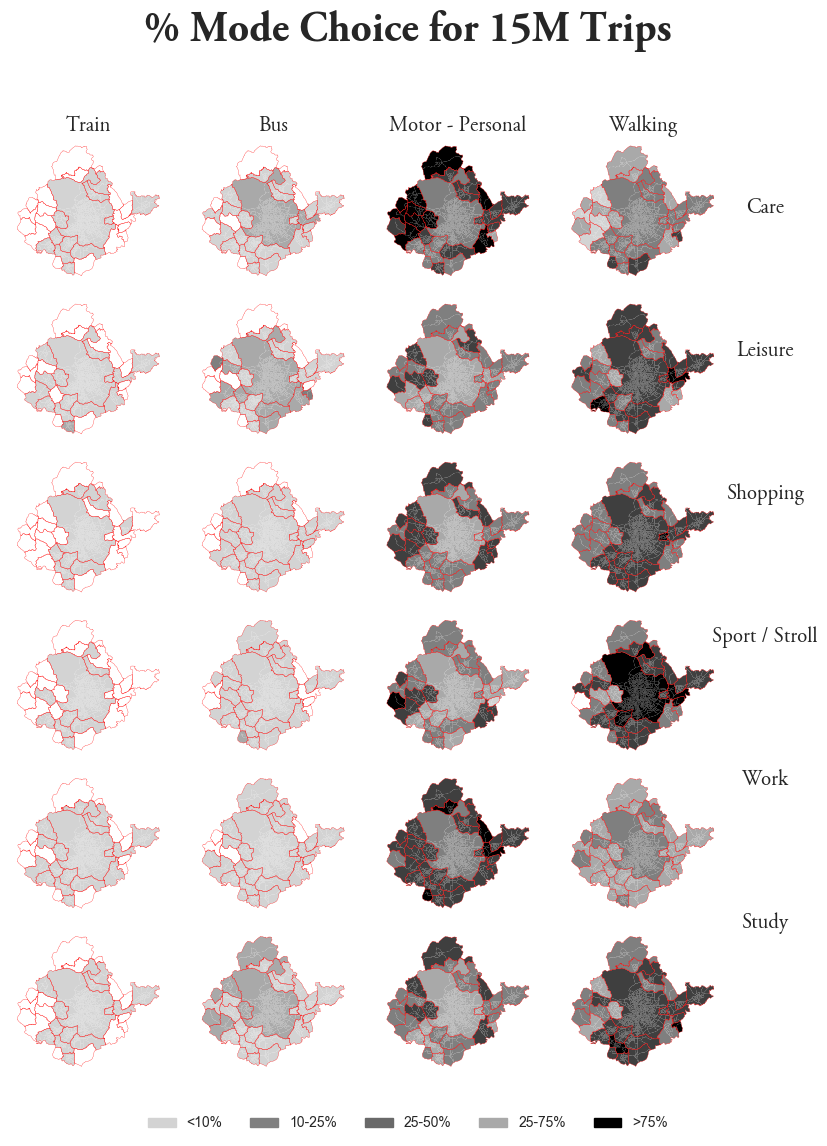

In [91]:
fig, ax = plt.subplots(6,4,figsize=(8.5,11),sharey=True,sharex=True)

# Apply the make_plot function for each row and column
modes = ['Train', 'Bus', 'Motor - Personal', 'Walking']
purposes = ['Care', 'Leisure', 'Shopping', 'Sport / Stroll', 'Work', 'Study']

for i, purpose in enumerate(purposes):
    make_plot(ax[i][0], 'Train',purpose)
    make_plot(ax[i][1], 'Bus',purpose)
    make_plot(ax[i][2], 'Motor - Personal',purpose)
    make_plot(ax[i][3], 'Walking',purpose)

"""

make_plot(ax[0][0],'Train','Care')
make_plot(ax[1][0],'Train','Leisure')
make_plot(ax[2][0],'Train','Shopping')
make_plot(ax[3][0],'Train','Sport / Stroll')
make_plot(ax[4][0],'Train','Work')
make_plot(ax[5][0],'Train','Study')

make_plot(ax[0][1],'Bus','Care')
make_plot(ax[1][1],'Bus','Leisure')
make_plot(ax[2][1],'Bus','Shopping')
make_plot(ax[3][1],'Bus','Sport / Stroll')
make_plot(ax[4][1],'Bus','Work')
make_plot(ax[5][1],'Bus','Study')

make_plot(ax[0][2],'Motor - Personal','Care')
make_plot(ax[1][2],'Motor - Personal','Leisure')
make_plot(ax[2][2],'Motor - Personal','Shopping')
make_plot(ax[3][2],'Motor - Personal','Sport / Stroll')
make_plot(ax[4][2],'Motor - Personal','Work')
make_plot(ax[5][2],'Motor - Personal','Study')

make_plot(ax[0][3],'Walking','Care')
make_plot(ax[1][3],'Walking','Leisure')
make_plot(ax[2][3],'Walking','Shopping')
make_plot(ax[3][3],'Walking','Sport / Stroll')
make_plot(ax[4][3],'Walking','Work')
make_plot(ax[5][3],'Walking','Study')
"""


# Add the global title
fig.suptitle('% Mode Choice for 15M Trips', fontweight='bold',**csfont)

# Add column titles
column_titles = ['Train', 'Bus', 'Motor - Personal', 'Walking']
for i, title in enumerate(column_titles):
    ax[0][i].set_title(title, **hfont)

# Add row titles (on the right side)
row_titles = ['Care', 'Leisure', 'Shopping', 'Sport / Stroll', 'Work', 'Study']
for i, title in enumerate(row_titles):
    fig.text(0.92, (5 - i) * 0.13 + 0.15, title, va='center', ha='center', **hfont)

# Create a single legend for all plots
import matplotlib.patches as mpatches

legend_labels = ['<10%', '10-25%', '25-50%', '25-75%', '>75%']
colors = ["lightgrey", "grey", "dimgray", "darkgrey", "black"]
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]

# Add legend outside the plot
fig.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, frameon=False)#,**csfont)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for titles and legend
plt.savefig(r"C:\Users\katul\OneDrive\Escritorio\choice_maps.jpg")
plt.show()
    



Auto Ownership

In [92]:
d = df[(df['Age']>18) & (df['Age']<65)]

In [93]:
d.HasVehicle.unique()

array(['Yes', 'No', nan], dtype=object)

In [94]:
d.drop_duplicates(subset='ID_HOGAR',inplace=True)

d = pd.concat(
    [d.groupby('VORIZT1259').sum()['ELE_HOGAR_NUEVO'].rename('Households'), d[d['HasVehicle']=='Yes'].groupby('VORIZT1259').sum()['ELE_HOGAR_NUEVO'].rename('HasVehicle')],axis=1)

d['%CarOwnership'] = (d['HasVehicle']*100)/d['Households']

d

#

C:\Users\katul\AppData\Local\Temp\ipykernel_9388\1763003082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.drop_duplicates(subset='ID_HOGAR',inplace=True)


TypeError: category type does not support sum operations

In [ ]:
housing_other_number
housing_sfr_number
housing_ch_number
housing_number
care_multiple_number
care_other_number
care_public_number
school_superior_number
school_other_number
school_basic_number
leisure_bar_number
leisure_cultural_number
leisure_other_number
leisure_shows_number
shopping_mall_number
shopping_other_number
shopping_market_number
shopping_alone_number
sport_other_number
sport_multiple_number
housing_area
care_multiple_area
care_other_area
care_public_area
school_superior_area
school_other_area
school_basic_area
leisure_bar_area
leisure_cultural_area
leisure_other_area
leisure_shows_area
shopping_mall_area
shopping_other_area
shopping_market_area
shopping_alone_area
sport_other_area
sport_multiple_area
office_area
industrial_area
storage_area
parking_area
unbuilt_area
hotel_area
religious_area
infra_area
parcel_built_area
parcel_area
parcel_built_ag
	

In [ ]:
fi, ax = plt.subplots(figsize=(8,8))
gpd.GeoDataFrame(pd.merge(d,gdf, left_index=True, right_on = 'ZT1259'), geometry = 'geometry').plot(
    column='%CarOwnership',linewidth = 0, cmap='RdBu',scheme = 'natural_breaks',ax=ax)

muni_ref.plot(linewidth=0.2, ax = ax,color='k')

ax.yaxis.set_label_text("")
ax.set_xlabel('') 
ax.axis('off')


In [ ]:
d